# Imports

In [1]:
from wisdm_data_extraction import load_wisdm
from hasctooldataprj_data_extraction import load_hasc
from shoiab_extraction import load_shoiab
from shoiab2_extraction import load_shoiab2
from pamap2_extraction import load_pamap2
from data_pre_processing import segmentations_pre_process, signals_pre_process, signals_to_spectrograms
import numpy as np
import optax
from models import SimplePipeline, PipelineAutoencoder, SimplePipelineBin, SimplePipelineClassification
from network_layers_definitions import  initialize_network, convolution_layer, dense_layer, normalize_signal, transposed_convolution_layer
import jax
import jax.numpy as jnp
from flax import linen as nn
import numpy as np
from metrics import f1_score, crossvalidate, crossvalidate_class
from data_generation import generate_signals
from metrics import give_bic_acc
from breakpoints_computation import get_strided_segmentations
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
import ruptures as rpt
from utils import find_change_indices

# Code : 

## Load databases

### Get the data:

To extract signals from the raw database, follow these steps:

1. Specify the path to the "Databases" folder on your machine in the file `main_constants.py`.
2. Use the following functions to load data from specific databases:
    - `load_wisdm`
    - `load_hasc`
    - `load_shoiab`
    - `load_shoiab2`
    - `load_pamap2`

You will receive three elements:

1. A list of arrays, where each array represents a signal. For example, a signal from an accelerometer containing axes x, y, z recorded during 1000 increments would be an array of shape `(1000, 3)`.
2. A list of lists where each list contains indexes representing the instant when a breakpoint occurs in the signal. For example, `[200, 306, 1000]`, where the last index should be the length of the considered signal.
3. A list of lists where each list contains the activities done by the subject between each breakpoint. For example, `["Walking", "Running", "Walking"]`.

In [2]:
raw_wisdm_signals, raw_wisdm_activities_indexes, raw_wisdm_activities = load_wisdm()
raw_hasc_signals, raw_hasc_activities_indexes, raw_hasc_activities = load_hasc()
raw_shoiab_signals, raw_shoiab_activities_indexes, raw_shoiab_activities = load_shoiab()
raw_shoiab2_signals, raw_shoiab2_activities_indexes, raw_shoiab2_activities = load_shoiab2()
raw_pamap2_signals, raw_pamap2_activities_indexes, raw_pamap2_activities = load_pamap2()

Loading WISDM database ...
Loading completed
Nb_signals :  32
Loading HascToolDataPrj database ...
Loading completed
Nb_signals :  18
Loading shoaib database...


/home/sblotas/time_series_segmentation/shoiab_extraction.py:23: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,28,29,30,31,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47,48,49,50,51,52,53,54,56,57,58,59,60,61,62,63,64,65,66,67,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(databases_path + "/SHOIAB/Participant_" + str(i) +".csv")
/home/sblotas/time_series_segmentation/shoiab_extraction.py:23: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,28,29,30,31,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47,48,49,50,51,52,53,54,56,57,58,59,60,61,62,63,64,65,66,67,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(databases_path + "/SHOIAB/Participant_" + str(i) +".csv")
/home/sblotas/time_series_segmentation/shoiab_extraction.py:23: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,

Loading completed
Nb_signals : 50
Loading shoiab2 database...
Loading completed
Number of signals loaded: 4
Loading pamap2 database...


/home/sblotas/time_series_segmentation/pamap2_extraction.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataCol["heartrate"].iloc[i]=100
/home/sblotas/time_series_segmentation/pamap2_extraction.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataCol["heartrate"].iloc[i]=100
/home/sblotas/time_series_segmentation/pamap2_extraction.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataCol["heartrate"].iloc[i]=100
/home/sblo

Loading completed
Nb_signals : 54


### Crop the signals:

For this project, we are utilizing the Python module called JAX, which employs specific computations to accelerate operations in the algorithm we are using. To achieve this acceleration, it is crucial to have data with a consistent shape, at least during the training phase of our model. That's why we have created the following function called `crop_signals`. This function takes arguments (signals, activities, activities_indexes, signal_max_length) and returns the adapted arguments with the specified fixed length, denoted as the `signal_max_length` variable.

To achieve this, we crop signals if their length is too long. If the length contains multiple times the `signal_max_length` variable, then multiple signals are created from one. If the signal is too short, we simply exclude it from the list. If you wish to crop your signals in another way, feel free to implement your own `crop_signals` function.


In [3]:
def crop_signals(signals, activities, activities_indexes, signal_max_length):
    # Initialize counters
    count = 0  # Counter for total signals kept
    signals_excluded_count = 0  # Counter for signals excluded due to length

    # Initialize new lists to store cropped signals, activities, and activity indexes
    new_signals, new_activities, new_activities_indexes = [], [], []

    # Iterate through each signal in the dataset
    for i in range(len(signals)):
        # Check if the length of the signal is greater than the specified maximum length
        if len(signals[i]) > signal_max_length:
            # Calculate the number of divisions based on signal_max_length
            n_divs = signals[i].shape[0] // signal_max_length
            
            # Iterate through each division
            buf = 0
            for j in range(n_divs):
                seg = []
                # Extract elements from activities_indexes within the current segment
                for element in activities_indexes[i]:
                    if (
                        element > j * signal_max_length
                        and element < (j + 1) * signal_max_length
                        and element != 0
                    ):
                        seg.append(element % signal_max_length)
                
                # If no elements were found, append signal_max_length to the segment
                if len(seg) == 0:
                    seg.append(signal_max_length)
                
                # If the last element in the segment is not signal_max_length, append it
                if seg[len(seg) - 1] != signal_max_length:
                    seg.append(signal_max_length)
                
                # If the segment has more than one element, update the new lists
                if len(seg) > 1:
                    new_activities_indexes.append(seg)
                    count += 1
                    new_signals.append(signals[i][j * signal_max_length : (j + 1) * signal_max_length])
                    new_activities.append(activities[i][buf:buf+len(new_activities_indexes[-1])])
                    buf += len(new_activities_indexes[-1]) - 1
        else:
            # Increment the signals_excluded_count for signals that don't meet the length criterion
            signals_excluded_count += 1

    # Print summary information
    print('Total signals:', count)
    print('Signals kept:', len(signals) - signals_excluded_count)
    print('Signals excluded:', signals_excluded_count)

    # Return the new lists
    return new_signals, new_activities, new_activities_indexes

# Set the signal_max_length
signal_max_length = 10000

# Apply the crop_signals function to multiple datasets
pamap2_signals, pamap2_activities, pamap2_activities_indexes = crop_signals(raw_pamap2_signals, raw_pamap2_activities, raw_pamap2_activities_indexes, signal_max_length)
wisdm_signals, wisdm_activities, wisdm_activities_indexes = crop_signals(raw_wisdm_signals, raw_wisdm_activities, raw_wisdm_activities_indexes, signal_max_length)
hasc_signals, hasc_activities, hasc_activities_indexes = crop_signals(raw_hasc_signals, raw_hasc_activities, raw_hasc_activities_indexes, signal_max_length)
shoiab_signals, shoiab_activities, shoiab_activities_indexes = crop_signals(raw_shoiab_signals, raw_shoiab_activities, raw_shoiab_activities_indexes, signal_max_length)
shoiab2_signals, shoiab2_activities, shoiab2_activities_indexes = crop_signals(raw_shoiab2_signals, raw_shoiab2_activities, raw_shoiab2_activities_indexes, signal_max_length)

Total signals: 528
Signals kept: 48
Signals excluded: 6
Total signals: 66
Signals kept: 31
Signals excluded: 1
Total signals: 18
Signals kept: 18
Signals excluded: 0
Total signals: 300
Signals kept: 50
Signals excluded: 0
Total signals: 20
Signals kept: 4
Signals excluded: 0


### Pre-process signals:

The next phase in correctly loading the databases involves the pre-processing of signals, which consists of two steps carried out by the `signals_pre_process` function:

1. **Low-Pass Filtering:** This step applies a low-pass filter to the signals with a cutoff frequency of 6 Hz. The choice of this frequency is based on the observation that human movements typically fall within this range. It is essential to specify the sample rate of the database at this point. The low-pass filter is designed to eliminate high-frequency noise while preserving the fundamental characteristics of the accelerometer data.

2. **Signal Centering and Scaling:** This step is crucial for ensuring numerical stability and facilitating model convergence during training. It involves two sub-steps:
    - Subtracting the mean of each dimension from the signals.
    - Dividing the signals by the standard deviation.

These operations help center the signals around zero and scale them appropriately, contributing to the overall effectiveness of the model training process.


In [4]:
wisdm_pre_process_sig = signals_pre_process(wisdm_signals, sample_rate = 20., cutoff_freq=6)
pamap2_pre_process_sig = signals_pre_process(pamap2_signals, sample_rate = 100., cutoff_freq=6)
hasc_pre_process_sig = signals_pre_process(hasc_signals, sample_rate = 100., cutoff_freq=6)
shoiab_pre_process_sig = signals_pre_process(shoiab_signals, sample_rate = 50., cutoff_freq=6)
shoiab2_pre_process_sig = signals_pre_process(shoiab2_signals, sample_rate = 50., cutoff_freq=6)

### Display the signals

Here is an example on how to display a signal and it's segmentation using the ruptures module : 

['Walking', 'Jogging']


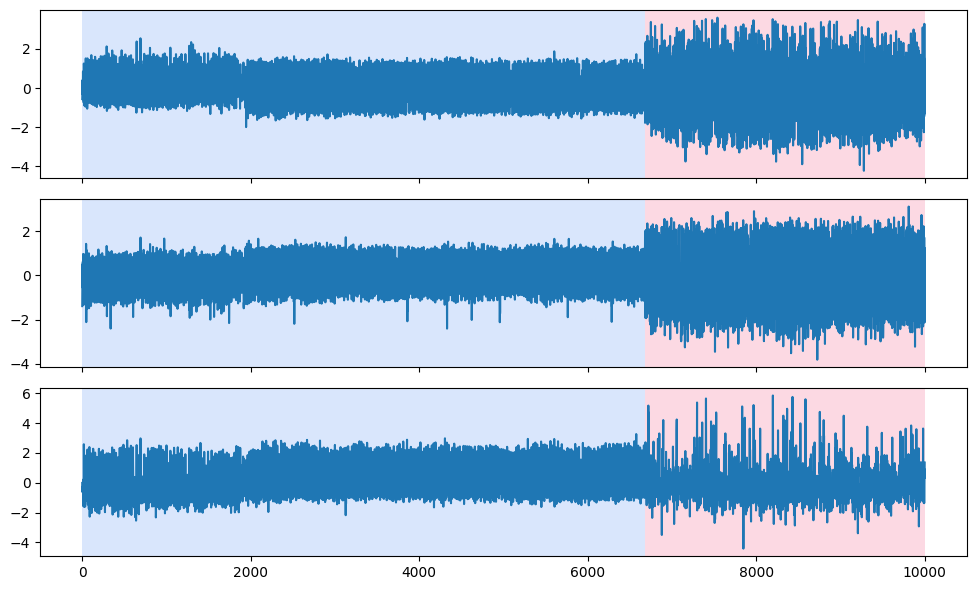

['Jogging', 'Walking', 'Jogging']


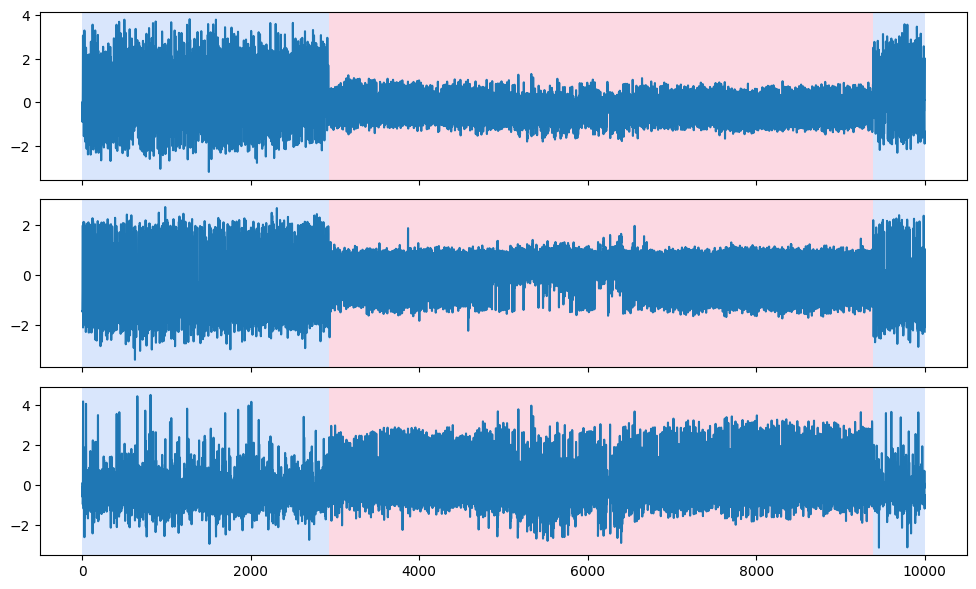

['Jogging', 'Upstairs', 'Downstairs', 'Upstairs', 'Downstairs']


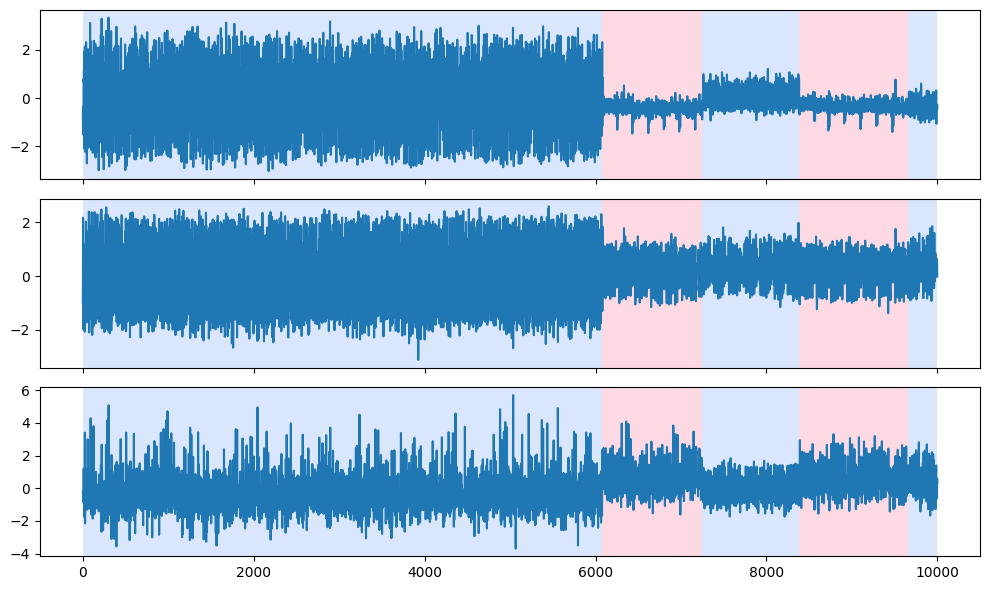

['Downstairs', 'Walking']


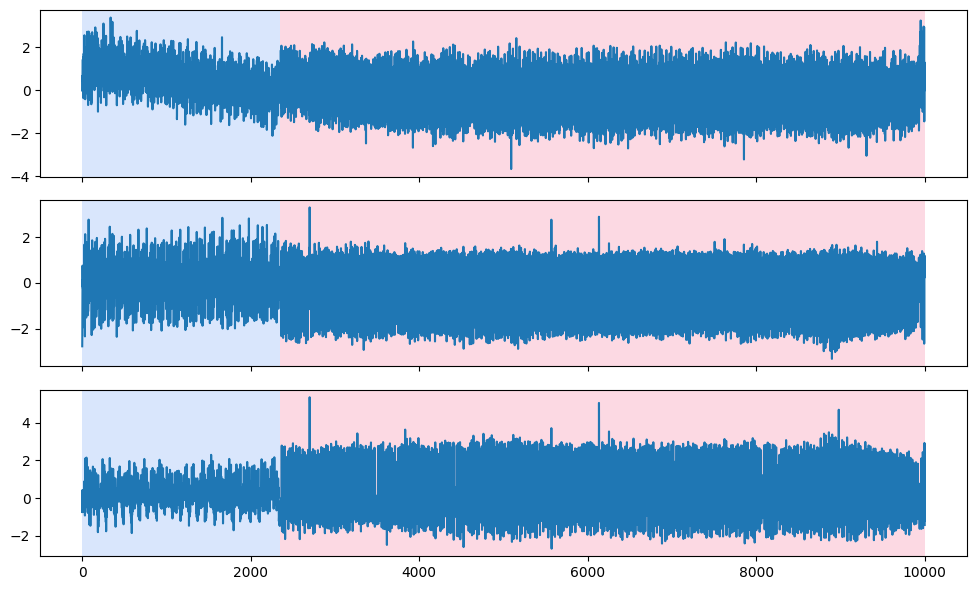

['Walking', 'Jogging']


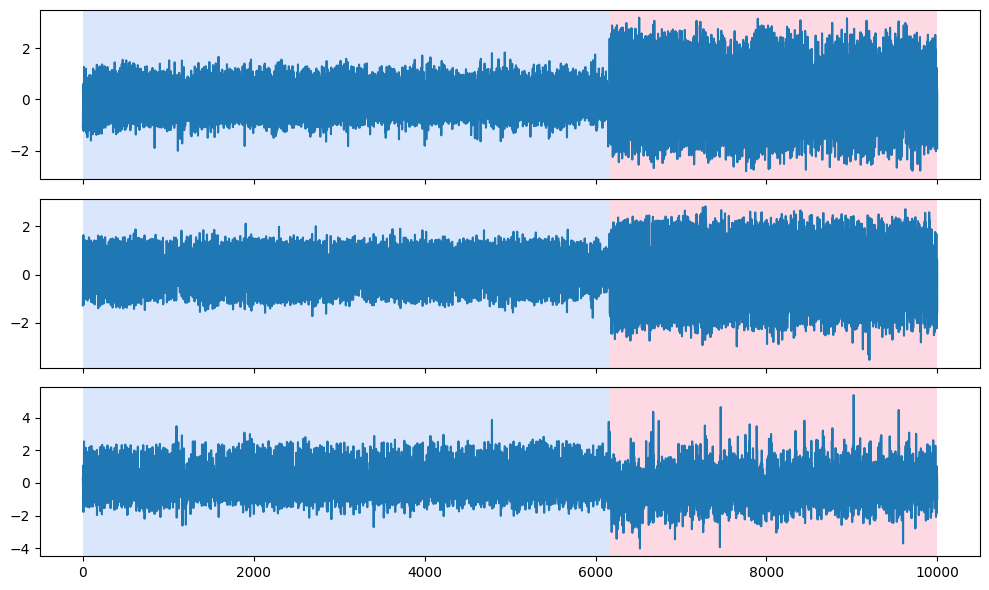

['Jogging', 'Walking', 'Jogging']


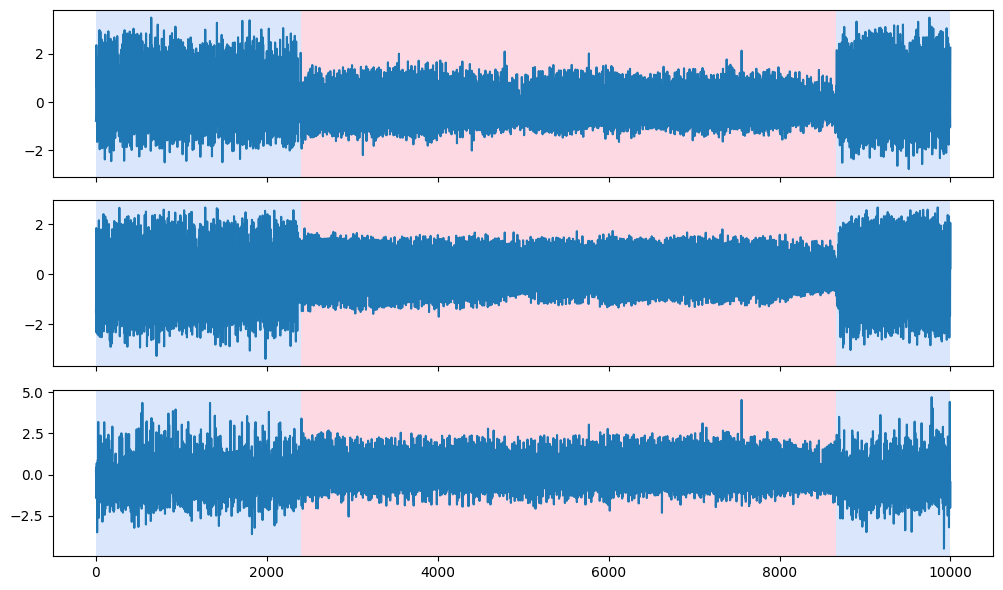

['Jogging', 'Upstairs', 'Downstairs', 'Upstairs', 'Downstairs', 'Upstairs']


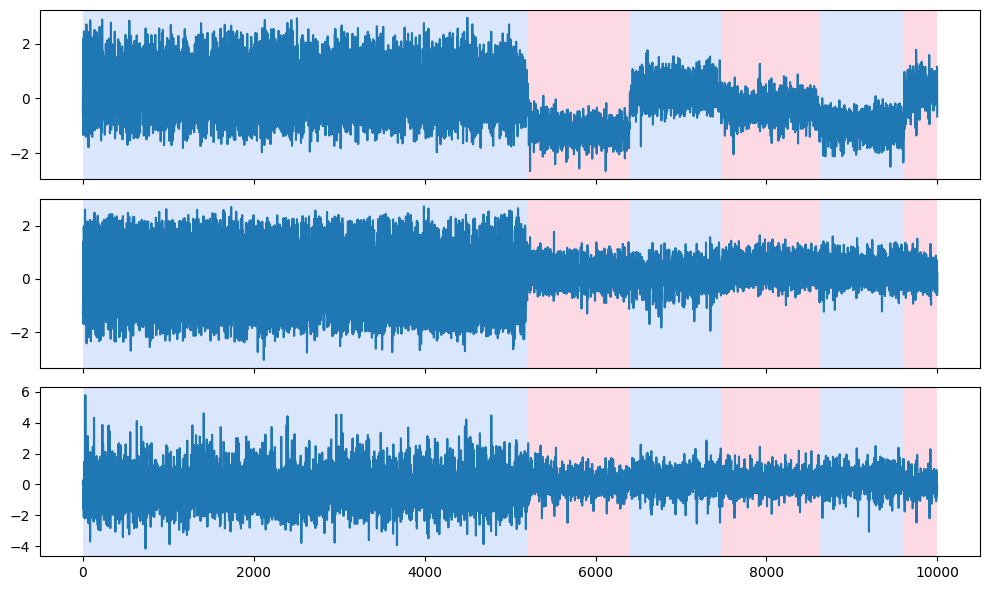

['Walking', 'Jogging']


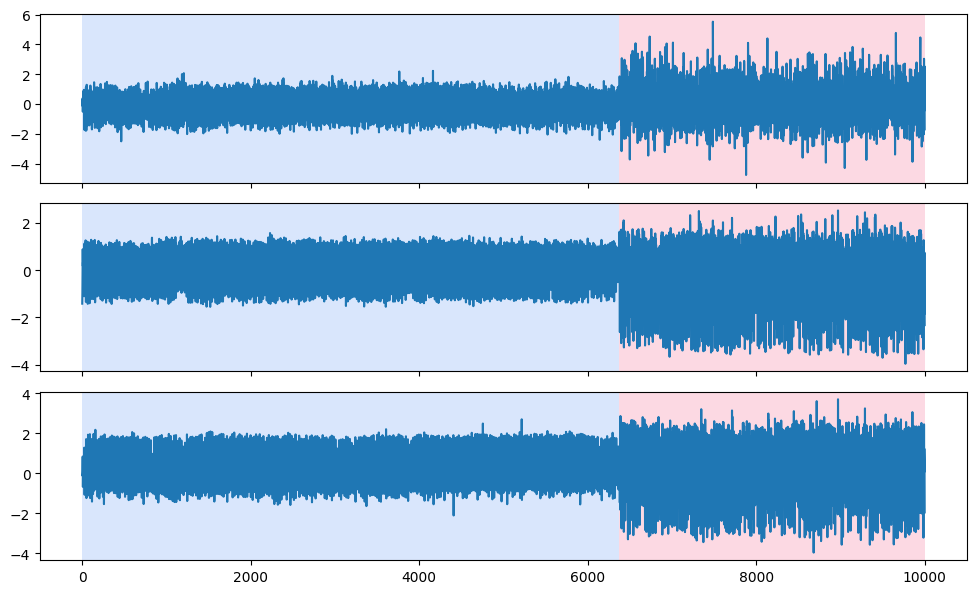

['Jogging', 'Walking', 'Jogging']


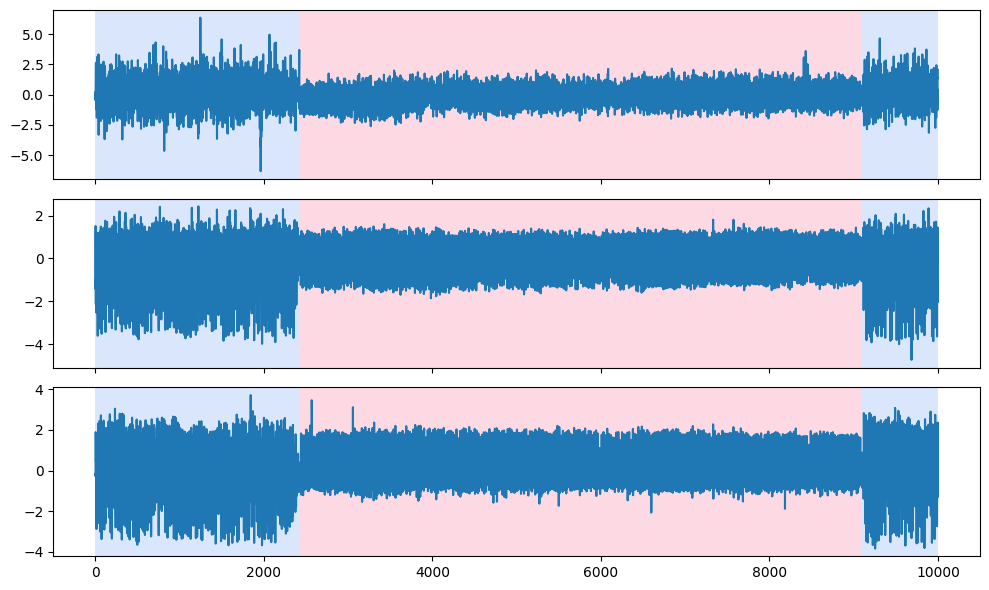

['Jogging', 'Upstairs', 'Downstairs', 'Upstairs', 'Downstairs']


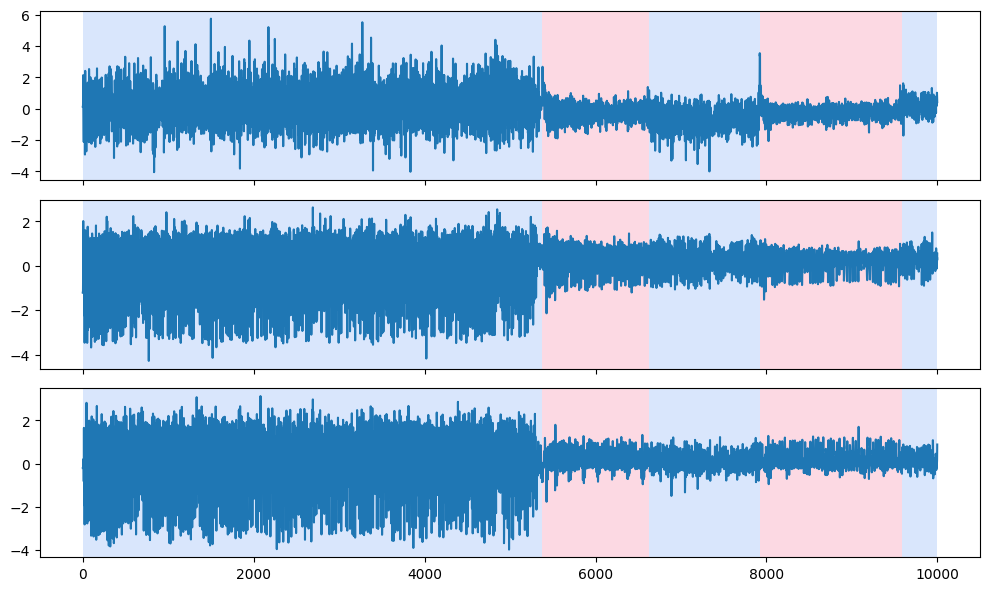

In [5]:
for i in range(10):
    print(wisdm_activities[i])
    rpt.display(wisdm_pre_process_sig[i], wisdm_activities_indexes[i])
    plt.show()

## Model Creation

In this repository, you have the opportunity to create a specialized model using a unique loss function derived from the segmentation computation on a transformed version of the signal. This specific loss is referred to as the 'segmentation loss.' The primary objective of building a pipeline is to train the model weights in such a way as to effectively minimize the 'segmentation loss.'

To achieve this, we've designed distinct pipelines, each with its own characteristics. Below, I'll outline the specifics of each pipeline, and afterward, I'll provide an example of how to implement them:

### 1. Transformation Pipeline:

This pipeline consists solely of a model with a transformation that you need to specify for the signal. Once this transformation is applied, the segmentation loss will be automatically computed on the transformed signal.

### 2. Encoder/Decoder Pipeline:

This pipeline is built on the conventional configuration of an encoder/decoder type network. The process involves:

- **Encoding the Signal:** Specify a method for encoding the signal. The segmentation loss will be computed on this encoded signal.
  
- **Decoding the Signal:** Specify a method for decoding the signal, returning a signal with the same size as the input. A new loss, called the "reconstruction loss," will be computed on this decoded signal. This loss emphasizes the differences between the input signal and the decoded signal.

The final loss for this pipeline is the sum of the segmentation and reconstruction losses, each multiplied by a regularization term. These regularization terms are denoted as $\lambda_{segmentation}$ and $\lambda_{reconstruction}$, respectively.

### 3. Binary classification Pipeline:

In this approach, we treat the signal segmentation problem as a binary classification task, where the objective is to classify each data point in the transformed signal as either a "breakpoint" or "not a breakpoint." 

First we transform the entry signal like in the transformation pipeline.

Then, for each data point in the transformed signal, we ensure that the final vector representing that point has a dimension of 2, which corresponds to the number of classes we are interested in. 

After the dimension adjustment, we apply a softmax to the resulting 2-dimensional signal. This classification step assigns a probability to each data point, indicating the likelihood of it being classified as a breakpoint or not.

To evaluate the performance of the binary classification approach, we compute the Binary Cross-Entropy loss. This loss quantifies the dissimilarity between the predicted classifications and the actual ground truth classifications, measuring how effectively our model distinguishes between breakpoints and non-breakpoints.

Following the softmax step, we perform a peak detection process on the resulting probabilities. This step involves the introduction of hyperparameters, such as the peak size and the gap between peaks.

### Transformation Pilpeline example

To create a transformation pipeline, as mentioned earlier, you must define the method by which you want your signal to be transformed before computing the 'segmentation loss.' To achieve this, you need to create a function called `transformation_method`, which takes the following arguments:

- **params:** A dictionary containing the parameters used for your transformation.
- **in_array:** The input signal in the form of a `jnp.array`, such as your preprocessed signal with a shape of (1000, 3).

**Note:** If you intend to leverage the computation capabilities of the JAX module, ensure that your function is JAX `jit` compatible.

Here's an example of a `transformation_method` function that performs two convolution layers, each separated by a ReLU activation function. Each convolution operation divides the signal length by two (stride parameter is set to 4). The output is then normalized to be between 0 and 1 before being returned.



In [6]:
@jax.jit
def transformation_method(params, in_array):
    """ Compute the forward pass for each example individually """
    input_ = jnp.expand_dims( in_array, axis = 0)
    out_conv_1 = convolution_layer(params['conv_layer_1_filter_weights'], params['conv_layer_1_bias'], input_, stride = 4 )
    out_relu_1 = nn.relu(out_conv_1)
    out_conv_2 = convolution_layer(params['conv_layer_2_filter_weights'], params['conv_layer_2_bias'], out_relu_1, stride = 4 )
    out_relu_2 = nn.relu(out_conv_2)
    output = normalize_signal(out_relu_2[0])
    return output 

Now that we have the `transformation_method`, we can define the function responsible for initializing the parameters used in our transformation, which we'll call `init_params`. This function needs to take the following arguments:

- **parameters_informations:** This argument should contain all the information necessary to specify the initialization of the parameters used in your transformation. For instance, it could be a list of kernel shapes.

- **beta_initial:** This represents the initial value of the parameter $\beta$ used in the segmentation loss computation. It gauges the intensity of the penalization related to predicting an incorrect number of breakpoints. (Refer to the documentation on the loss for more details.)

- **verbose:** A boolean argument specifying whether you want to print text during the parameter initialization process (usually set to false by default).

The `init_params` function should return a dictionary, `params`, containing the necessary parameters for your transformation as well as the parameter 'beta'. For example, in this case, we are using a pre-implemented function called `initialize_network` defined in the file `network_layers_definitions.py`.



Here is an example of initializing the parameters associated with the previously specified `transformation_method`. In this example, we define the dimensions for the parameters as follows:

- **First convolution kernel:** (300, 3, 3)  # (temporal_length, input_dimension, output_dimension)
- **Second convolution kernel:** (300, 3, 3)
- **Beta initial value:** log(10)  # The beta is set using an exponential function to ensure its positivity; here, the beta value is 10.



In [7]:
layer_sizes = []
conv_layer_params = [(1, 100, 3, 3), (1, 100, 3, 3)]
tr_conv_layer_params = []
parameters_informations = [layer_sizes, conv_layer_params, tr_conv_layer_params]

Now we can easily create the pipeline using the following function : 

In [8]:
transformation_pipeline = SimplePipeline(transformation_method, initialize_network, parameters_informations)

Parameters:
conv_layer_1_filter_weights - Shape: (100, 3, 3)
conv_layer_1_bias - Shape: (100, 3, 3)
conv_layer_2_filter_weights - Shape: (100, 3, 3)
conv_layer_2_bias - Shape: (100, 3, 3)
beta - Shape: ()


**Lastly:** You need to specify the final length of the signal after your transformation. This information is crucial for training the model later on. In this example, we have downsized the signal twice, resulting in a signal length that is divided by 4:



In [9]:
transformed_signal_length = int(signal_max_length / 4)

### Encoder/Decoder Pipeline example

To create a encoder/decoder pipeline, as mentioned earlier, you must define the method by which you want your signal to be encoded before computing the 'segmentation loss' and the method by which you want your encoded signal to be decoded before computing the 'reconstruction loss'. 
To achieve this, you need to create two functions called `endocer` and `dedocer`, which takes the following arguments:

- **params:** A dictionary containing the parameters used for your transformation.
- **in_array:** The input signal in the form of a `jnp.array`, such as your preprocessed signal with a shape of (1000, 3).
- **(only for the decoder)adapted_jnp_segmentations:** A `jnp.array` of shape `(transformed_signal_length)` corresponding to a signal where we increment by one each time there is a breakpoint in the original segmentation (this way we retain the information contained in the object segmentation but with a fixed size). The way to aquire this element is explain later in the notebook.

**Note:** If you intend to leverage the computation capabilities of the JAX module, ensure that your function is JAX `jit` compatible.

Here's an example of a `endocer` and `dedocer` function that performs multiple convolution layers, each separated by a geLU activation function inspitate by the paper. (DETECTING CHANGE POINTS IN TIME SERIES VIA
CURVATURES OF REPRESENTATION TRAJECTORIES).
The encoder uses convolutions with stride argument that reduce the signal length and so the decoder uses transposed convolutions with stride as well to re-obtain a signal with the same length as the entry.

In [10]:
@jax.jit
def encoder(params, in_array):
    input_ = jnp.expand_dims( in_array, axis = 0)
    
    residual_1 = input_[:, ::2, :]
    out_relu_1 = nn.gelu(input_)
    out_conv_1 = convolution_layer(params['conv_layer_1_filter_weights'],None, out_relu_1, stride = 4, rhs_dilation=(1,) )
    out_relu_1_bis = nn.gelu(out_conv_1)
    out_conv_1_bis = convolution_layer(params['conv_layer_2_filter_weights'],None, out_relu_1_bis, rhs_dilation=(1,) )
    output_1 = out_conv_1_bis + residual_1
    
    residual_2 = output_1[:, ::2, :]
    out_relu_2 = nn.gelu(output_1)
    out_conv_2 = convolution_layer(params['conv_layer_3_filter_weights'],None, out_relu_2, stride = 4, rhs_dilation=(2,) )
    out_relu_2_bis = nn.gelu(out_conv_2)
    out_conv_2_bis = convolution_layer(params['conv_layer_4_filter_weights'],None, out_relu_2_bis, rhs_dilation=(2,))
    output_2 = out_conv_2_bis + residual_2

    residual_3 = output_2
    out_relu_3 = nn.gelu(output_2)
    out_conv_3 = convolution_layer(params['conv_layer_5_filter_weights'],None, out_relu_3, rhs_dilation=(4,) )
    out_relu_3_bis = nn.gelu(out_conv_3)
    out_conv_3_bis = convolution_layer(params['conv_layer_6_filter_weights'],None, out_relu_3_bis, rhs_dilation=(4,))
    output_3 = out_conv_3_bis + residual_3

    residual_4 = output_3
    out_relu_4 = nn.gelu(output_3)
    out_conv_4 = convolution_layer(params['conv_layer_7_filter_weights'],None, out_relu_4, rhs_dilation=(16,) )
    out_relu_4_bis = nn.gelu(out_conv_4)
    out_conv_4_bis = convolution_layer(params['conv_layer_8_filter_weights'],None, out_relu_4_bis, rhs_dilation=(16,))
    output_4 = out_conv_4_bis + residual_4

    output = normalize_signal(output_2[0])
    
    return output

@jax.jit
def decoder(params, in_array, jnp_segmentation):
    segmented_augmented = jnp.expand_dims( in_array, axis = 0)
    out_tr_conv_1 = transposed_convolution_layer(params['tr_conv_layer_1_filter_weights'],None, segmented_augmented, stride = 4 )
    out_relu_1 = out_tr_conv_1
    out_tr_conv_2 = transposed_convolution_layer(params['tr_conv_layer_2_filter_weights'],None, out_relu_1, stride = 4, rhs_dilation=(2,))
    out_relu_2 = out_tr_conv_2
    out_tr_conv_3 = transposed_convolution_layer(params['tr_conv_layer_3_filter_weights'],None, out_relu_2, rhs_dilation=(4,))
    out_relu_3 = out_tr_conv_3
    out_tr_conv_4 = transposed_convolution_layer(params['tr_conv_layer_4_filter_weights'],None, out_relu_3, rhs_dilation=(8,))
    return out_tr_conv_4[0]


Similar to the case of the transformation pipeline, you need to specify a method to initialize the parameters used in your encoder and decoder. Once again, you can use the method called `initialize_network`.

In [11]:
layer_sizes = []
conv_layer_params = [(1, 100, 3, 3), (1, 100, 3, 3), (1, 100, 3, 3), (1, 100, 3, 3),(1, 100, 3, 3), (1, 100, 3, 3), (1, 100, 3, 3), (1, 100, 3, 3)]
tr_conv_layer_params = [(1, 100, 3, 3), (1, 100, 3, 3), (1, 100, 3, 3), (1, 100, 3, 3)]
encoder_method, decoder_method, network_inizializer, parameters_informations = encoder, decoder, initialize_network, [layer_sizes, conv_layer_params, tr_conv_layer_params]

This time, when you create your pipeline, you have the option to choose the regularization factors that will be applied before the segmentation loss and the reconstruction loss. These regularization terms are denoted as $\lambda_{segmentation}$ and $\lambda_{reconstruction}$, respectively.

When constructing your encoder/decoder pipeline, you can specify these regularization factors in the initialization of your pipeline. Here's an example:


In [12]:
lambda_reconstruction = 1.
lambda_segmentation = 1.
autoencoder_pipeline = PipelineAutoencoder(encoder_method, decoder_method, network_inizializer, parameters_informations, lambda_reconstruction = lambda_reconstruction, lambda_segmentation=lambda_segmentation)

Parameters:
conv_layer_1_filter_weights - Shape: (100, 3, 3)
conv_layer_1_bias - Shape: (100, 3, 3)
conv_layer_2_filter_weights - Shape: (100, 3, 3)
conv_layer_2_bias - Shape: (100, 3, 3)
conv_layer_3_filter_weights - Shape: (100, 3, 3)
conv_layer_3_bias - Shape: (100, 3, 3)
conv_layer_4_filter_weights - Shape: (100, 3, 3)
conv_layer_4_bias - Shape: (100, 3, 3)
conv_layer_5_filter_weights - Shape: (100, 3, 3)
conv_layer_5_bias - Shape: (100, 3, 3)
conv_layer_6_filter_weights - Shape: (100, 3, 3)
conv_layer_6_bias - Shape: (100, 3, 3)
conv_layer_7_filter_weights - Shape: (100, 3, 3)
conv_layer_7_bias - Shape: (100, 3, 3)
conv_layer_8_filter_weights - Shape: (100, 3, 3)
conv_layer_8_bias - Shape: (100, 3, 3)
tr_conv_layer_1_filter_weights - Shape: (100, 3, 3)
tr_conv_layer_1_bias - Shape: (100, 3, 3)
tr_conv_layer_2_filter_weights - Shape: (100, 3, 3)
tr_conv_layer_2_bias - Shape: (100, 3, 3)
tr_conv_layer_3_filter_weights - Shape: (100, 3, 3)
tr_conv_layer_3_bias - Shape: (100, 3, 3)
tr

Once again, it's crucial to specify the `transformed_signal_length` when creating your Encoder/Decoder pipeline:


In [13]:
transformed_signal_length = int(signal_max_length / 4)

### Binary classification example :

To create a Binary Classification pipeline, similar to the transformation pipeline, you need to implement the method by which you want your signal to be transformed before computing the 'classification loss'. To achieve this, you need to create a function called `transformation_method_bin`, which takes the following arguments:

- **params:** A dictionary containing the parameters used for your transformation.
- **in_array:** The input signal in the form of a `jnp.array`, such as your preprocessed signal with a shape of (1000, 3).

**Note:** If you intend to leverage the computation capabilities of the JAX module, ensure that your function is JAX `jit` compatible.

**Important:** The final output dimension needs to be 2 and between 0 and 1, so the binary classification loss can be computed efficiently. To achieve this, you can use a `softmax` function after a dense layer that brings your signal to dimension 2.

Here's an example of a `transformation_method_bin` function that perform multiple convolution layers:



In [14]:
@jax.jit
def transformation_method_bin(params, in_array):
    """ Compute the forward pass for each example individually """
    input_ = jnp.expand_dims( in_array, axis = 0)
    out_conv_1 = convolution_layer(params['conv_layer_1_filter_weights'], params['conv_layer_1_bias'], input_, stride = 4 )
    out_relu_1 = nn.relu(out_conv_1)
    out_conv_2 = convolution_layer(params['conv_layer_2_filter_weights'], params['conv_layer_2_bias'], out_relu_1, stride = 4 )
    out_relu_2 = nn.relu(out_conv_2)
    out_dense_1 = dense_layer(params['linear_layer_1_weights'], params['linear_layer_1_bias'], out_relu_2)
    out_dense_2 = dense_layer(params['linear_layer_2_weights'], params['linear_layer_2_bias'], out_dense_1)
    output = normalize_signal(out_relu_2[0])
    softmax_result = jnp.exp(output) / jnp.sum(jnp.exp(output), axis=1, keepdims=True)
    return softmax_result

Similar to the case of the transformation pipeline, you need to specify a method to initialize the parameters used in your encoder and decoder. Once again, you can use the method called `initialize_network`.

In [15]:
layer_sizes = [(10,2),(2,10)]
conv_layer_params = [(1, 300, 3, 3), (1, 300, 3, 2)]
tr_conv_layer_params = []
parameters_informations = [layer_sizes, conv_layer_params, tr_conv_layer_params]

Now we can easily create the pipeline using the following function, you can modify the term alpha that regulate the penalty on false negativ for cross entropy(see documentation) : 

In [16]:
transformation_pipeline_bin = SimplePipelineBin(transformation_method_bin, initialize_network, parameters_informations, alpha=1000)

Parameters:
linear_layer_1_weights - Shape: (2, 10)
linear_layer_1_bias - Shape: (2,)
linear_layer_2_weights - Shape: (10, 2)
linear_layer_2_bias - Shape: (10,)
conv_layer_1_filter_weights - Shape: (300, 3, 3)
conv_layer_1_bias - Shape: (300, 3, 3)
conv_layer_2_filter_weights - Shape: (300, 3, 2)
conv_layer_2_bias - Shape: (300, 3, 2)
beta - Shape: ()


Once again, it's crucial to specify the `transformed_signal_length` when creating your Binary classification pipeline:


In [17]:
transformed_signal_length = int(signal_max_length / 4)

## Fourier Transformation

A particular case is when you use, as a supplementary step in signal processing, the transformation to the Fourier space. You can achieve this using the transformation pipeline. Of course, you can modify the transformation method to the specificity of the Fourier space. The stride parameter of the convolution might need adjustment because the transition to a spectrogram already reduces the signal length. Here is an example implementation of `transformation_method_fourier`:


In [18]:
@jax.jit
def transformation_method_fourier(params, in_array):
    """ Compute the forward pass for each example individually """
    input_ = jnp.expand_dims( in_array, axis = 0)
    out_conv_1 = convolution_layer(params['conv_layer_1_filter_weights'], params['conv_layer_1_bias'], input_)
    out_relu_1 = nn.relu(out_conv_1)
    out_conv_2 = convolution_layer(params['conv_layer_2_filter_weights'], params['conv_layer_2_bias'], out_relu_1)
    out_relu_2 = nn.relu(out_conv_2)
    out_dense_1 = dense_layer(params['linear_layer_1_weights'], params['linear_layer_1_bias'], out_relu_2)
    out_dense_2 = dense_layer(params['linear_layer_2_weights'], params['linear_layer_2_bias'], out_dense_1)
    output = normalize_signal(out_dense_2[0])
    return output 

In this case, what's different is the inclusion of new parameters for the Fourier transformation, particularly when applied to a spectrogram. You can modify these parameters based on your preferences:

- **nperseg:** The window length for spectrogram computation.
- **noverlap:** The overlapping of the window. Changing this parameter will affect the output signal length (the formula to correctly compute the change in length is specified later in the notebook).
- **n_dims:** The dimension of the entry after the passage to Fourier space. This is equal to `(nperseg // 2 + 1)`.

Once you determine these parameters, you can adapt the size of the kernel you are using. Here's an example implementation with explanations:



In [19]:
nperseg=300
n_dims = int(nperseg/2 +1)
noverlap=292
# Example usage with linear and convolutional layers
layer_sizes = [(10,n_dims), (2,10)]
conv_layer_params = [(1, 300, n_dims, n_dims), (1, 300, n_dims, n_dims)]  # (Broadcast dimension, temporal_lenght, input_dimsension, output_dimension)
parameters_informations = [layer_sizes, conv_layer_params, tr_conv_layer_params]

Here is the way to convert the signal into spectrograms. Be careful; you need to specify `fs` as the sample rate used for the capture of the database you are using:


In [20]:
wisdm_spectrograms = signals_to_spectrograms(wisdm_pre_process_sig, nperseg=nperseg, noverlap=noverlap, fs=20)
hasc_spectrograms = signals_to_spectrograms(hasc_pre_process_sig, nperseg=nperseg, noverlap=noverlap, fs=100)

Now you can create your pipeline with Fourier transformation, just like with the simple transformation pipeline:

In [21]:
pipeline_fourier = SimplePipeline(transformation_method_fourier, initialize_network, parameters_informations)

Parameters:
linear_layer_1_weights - Shape: (151, 10)
linear_layer_1_bias - Shape: (151,)
linear_layer_2_weights - Shape: (10, 2)
linear_layer_2_bias - Shape: (10,)
conv_layer_1_filter_weights - Shape: (300, 151, 151)
conv_layer_1_bias - Shape: (300, 151, 151)
conv_layer_2_filter_weights - Shape: (300, 151, 151)
conv_layer_2_bias - Shape: (300, 151, 151)
beta - Shape: ()


Don't forget to specify the length of the transformed signal. Here, the formula is as follows (it can change if you add stride to your convolution in the transformation method):

In [22]:
transformed_signal_length = int(signal_max_length / (nperseg - noverlap))

## Train a Model



In this section, we specify how to train a model using our repository. After creating your pipeline as detailed in the "Model Creation" section (don't forget to create the variable `transformed_signal_length` corresponding to the length of your transformed signal before breakpoint computation), you'll need to adapt the segmentation to the size you chose for your transformed signal.

As explained earlier, to benefit from the faster computation provided by the JAX module, it is essential to work with objects of the same size. While we transformed the signals to objects of the same shape, the same isn't true for our segmentation, which is still a simple list of multiple indexes corresponding to the places where breakpoints occur in the pre-processed signal. To address this, we created a function called `segmentations_pre_process`.

This function takes the following arguments:
- **segmentations:** the original segmentation of the signal, for example, [200, 2000, 8000, 10000].
- **transformed_signal_length:** the length of the transformed signal, here: 2500 (10000/4).
- **signal_max_length:** the length of the original signal.

The function returns the following transformations of the segmentation:
- **jnp_segmentations:** a `jnp.array` of shape `(signal_max_length)` corresponding to a signal where we increment by one each time there is a breakpoint in the original segmentation (this way we retain the information contained in the object segmentation but with a fixed size).
- **size_adapted_segmentations:** a list of indexes corresponding to the breakpoints on the transformed signal. Here, we divide by 4 the size of the signal, so the segmentation [200, 2000, 8000, 10000] becomes [50, 500, 2000, 2500].
- **adapted_jnp_segmentations:** similar to `jnp_segmentations`, but this time we transform the `size_adapted_segmentations` into a `jnp.array` of shape `(transformed_signal_length)`.




In [23]:
transformed_signal_length = int(signal_max_length / 4)
wisdm_jnp_segmentations, wisdm_size_adapted_segmentations, wisdm_size_adapted_jnp_segmentations = segmentations_pre_process(wisdm_activities_indexes, transformed_signal_length, signal_max_length)


Now, to train your model, you only need to use the following lines of code (feel free to adapt the number of epochs, or the batch size):



/home/sblotas/time_series_segmentation/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sblotas/time_series_segmentation/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch 1 | T: 8.29 | Train A: nan | Test A: nan | Loss:  18.1311 | pen = exp(Beta): 8.80268
Epoch 2 | T: 1.71 | Train A: nan | Test A: nan | Loss:  11.7666 | pen = exp(Beta): 7.77479
Epoch 3 | T: 0.65 | Train A: nan | Test A: nan | Loss:  9.0178 | pen = exp(Beta): 6.89296
Epoch 4 | T: 0.65 | Train A: nan | Test A: nan | Loss:  7.1449 | pen = exp(Beta): 6.11911
Epoch 5 | T: 0.65 | Train A: nan | Test A: nan | Loss:  5.8337 | pen = exp(Beta): 5.46097
Epoch 6 | T: 0.66 | Train A: nan | Test A: nan | Loss:  4.9873 | pen = exp(Beta): 4.86918
Epoch 7 | T: 0.66 | Train A: nan | Test A: nan | Loss:  4.3000 | pen = exp(Beta): 4.35218
Epoch 8 | T: 0.66 | Train A: nan | Test A: nan | Loss:  3.5346 | pen = exp(Beta): 3.88432
Epoch 9 | T: 0.66 | Train A: nan | Test A: nan | Loss:  3.3261 | pen = exp(Beta): 3.46128
Epoch 10 | T: 0.68 | Train A: nan | Test A: nan | Loss:  2.7431 | pen = exp(Beta): 3.10807


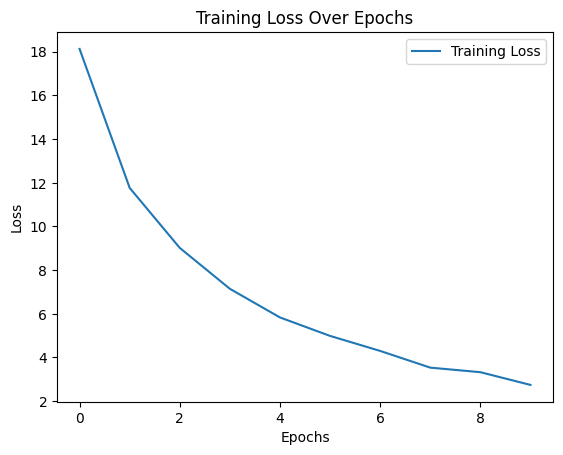

In [24]:
X = wisdm_pre_process_sig #signals
y = wisdm_size_adapted_jnp_segmentations

train_loss, opt_state, params = transformation_pipeline.fit(X,y,verbose=True, batch_size=5, num_epochs=10)

# Plot the training loss
plt.plot(train_loss, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Display results of a model :


To display a quick analysis of the results, you can use the following line of code. This will plot all the signals you provided along with a colored background corresponding to the true segmentation and with dotted lines indicating the predicted segmentation given by the model.

The code snippet will also provide an F1 score for the prediction. More detailed information on how the F1 score is computed can be found in the documentation. The F1 score is calculated with a margin, which is printed when you launch the function. The margin is set by default to 5% of the transformed signal length.



Used margin =  125.0
--------------------------------------
Signal n°  0
True segmentation : [1668 2500]
Predicted segmentation : [1662 2500]
F1 score : 1.0


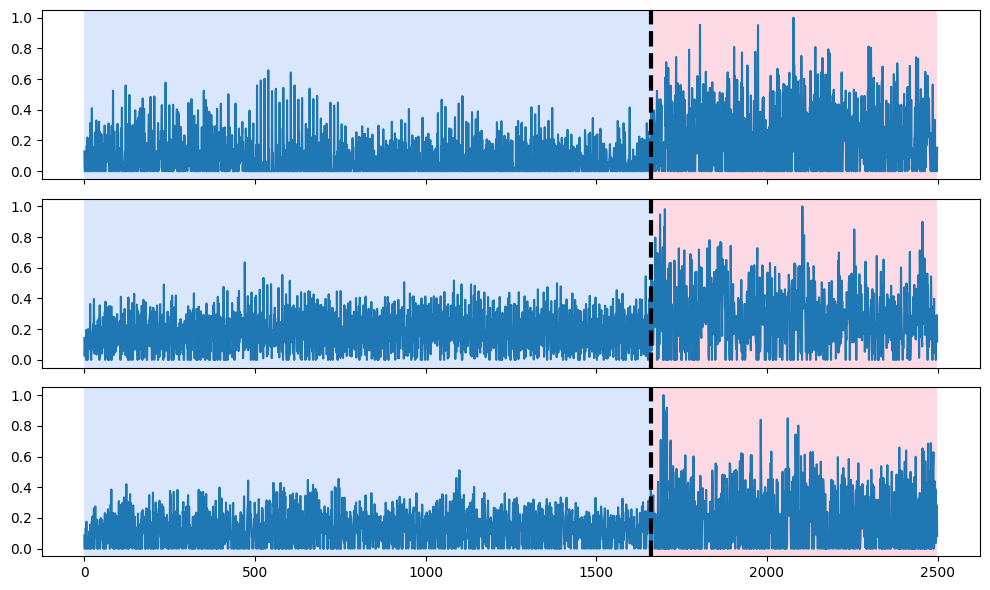

Signal n°  1
True segmentation : [ 731 2345 2500]
Predicted segmentation : [ 735 2343 2500]
F1 score : 1.0


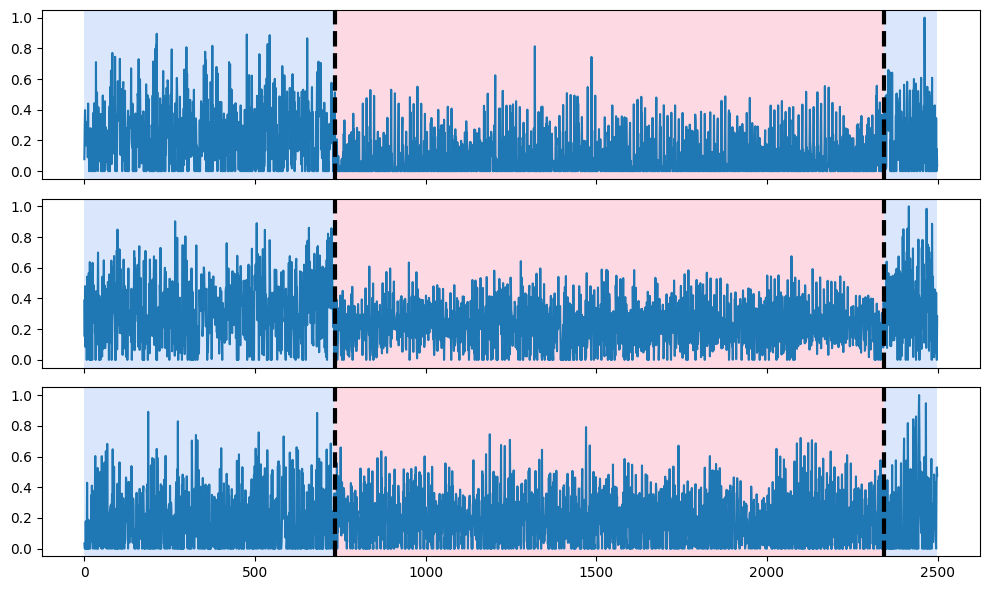

Signal n°  2
True segmentation : [1520 1813 2095 2414 2500]
Predicted segmentation : [1520 2500]
F1 score : 0.4


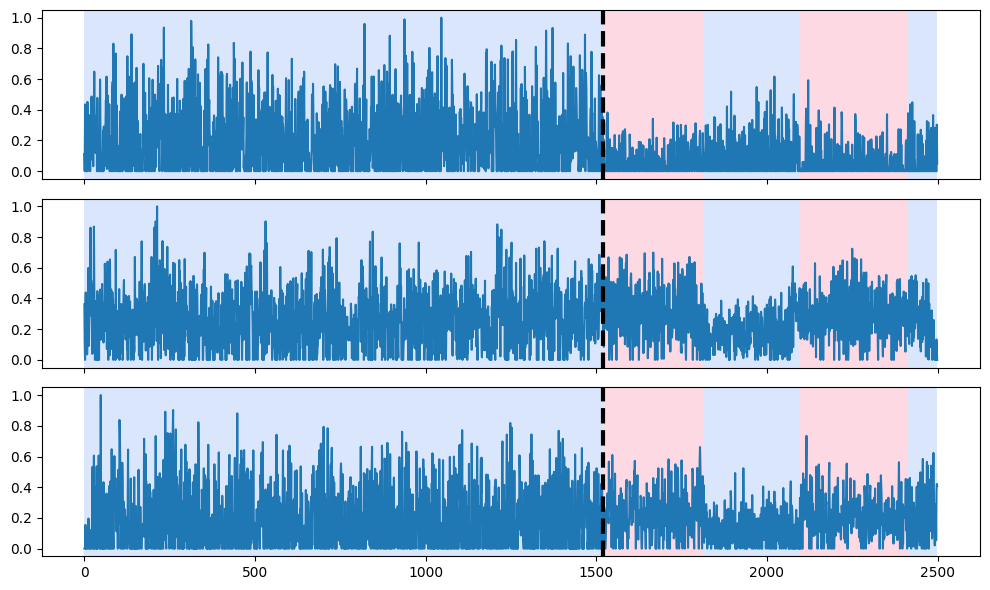

Signal n°  3
True segmentation : [ 587 2500]
Predicted segmentation : [ 553 2500]
F1 score : 1.0


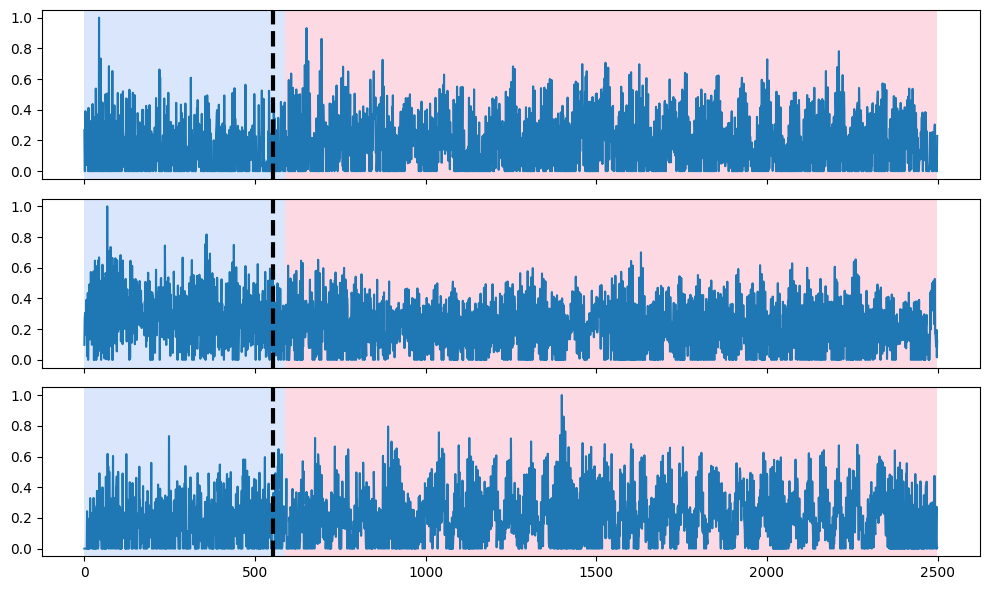

Signal n°  4
True segmentation : [1539 2500]
Predicted segmentation : [1543 2500]
F1 score : 1.0


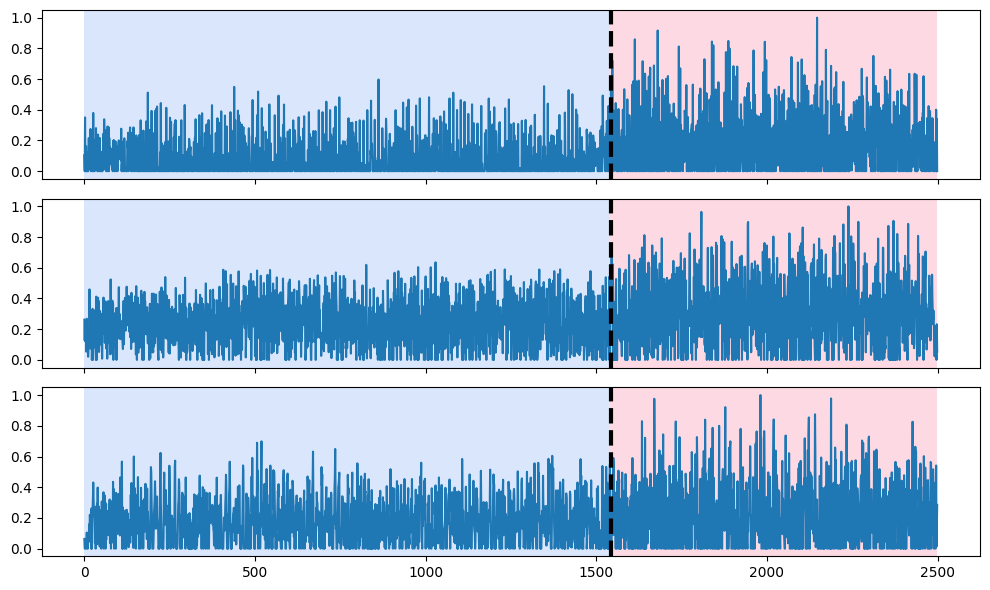

Signal n°  5
True segmentation : [ 599 2164 2500]
Predicted segmentation : [ 596 2180 2500]
F1 score : 1.0


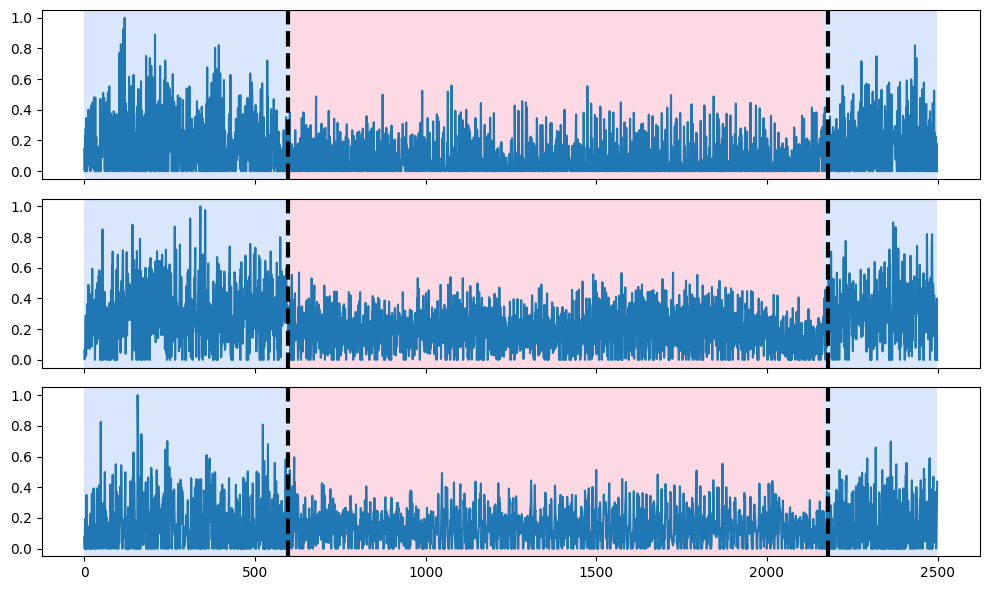

Signal n°  6
True segmentation : [1302 1599 1866 2153 2403 2500]
Predicted segmentation : [1300 1598 2500]
F1 score : 0.5714285714285715


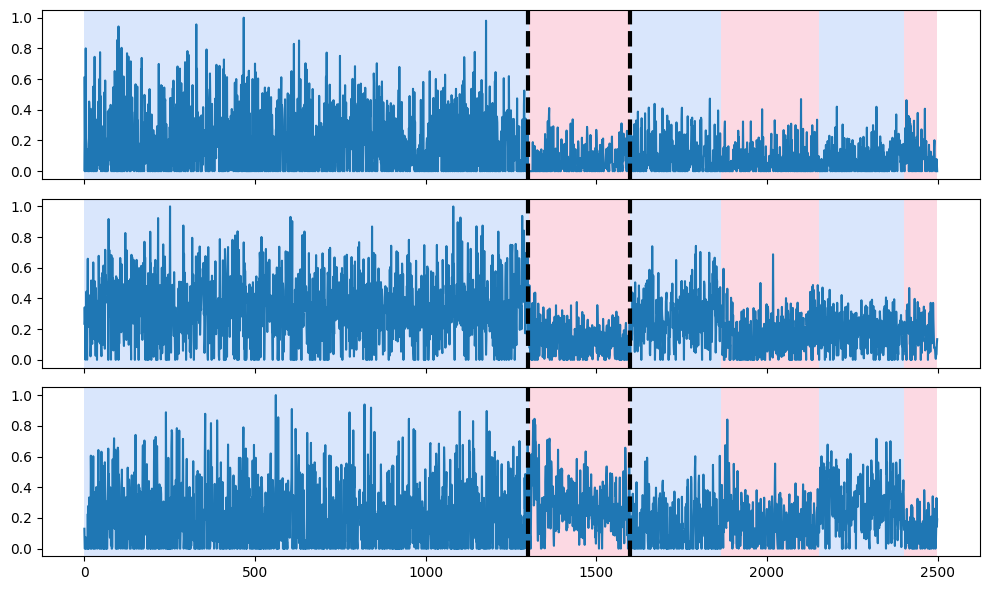

Signal n°  7
True segmentation : [1592 2500]
Predicted segmentation : [1592 2500]
F1 score : 1.0


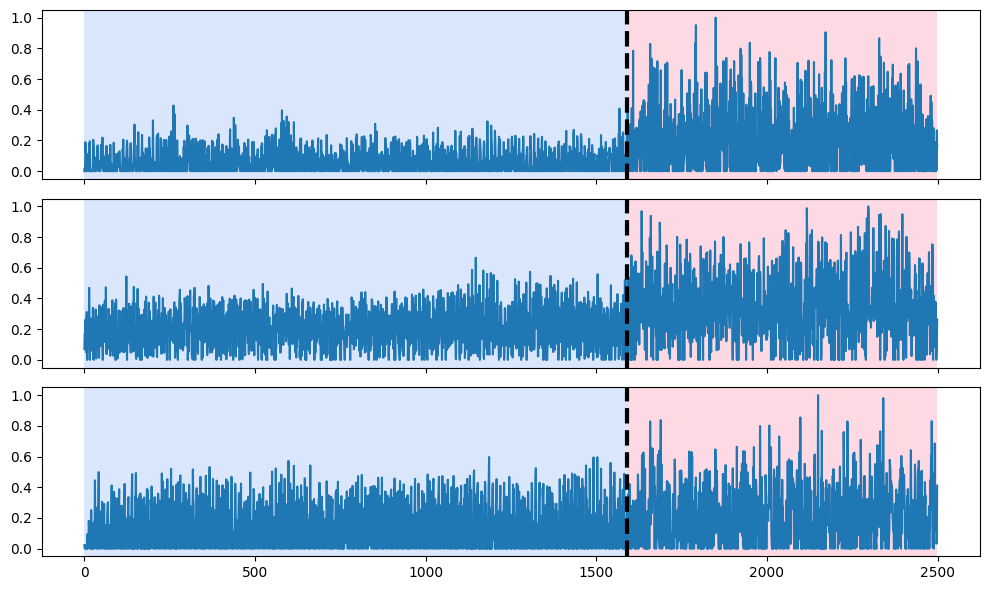

Signal n°  8
True segmentation : [ 605 2274 2500]
Predicted segmentation : [ 605 2282 2500]
F1 score : 1.0


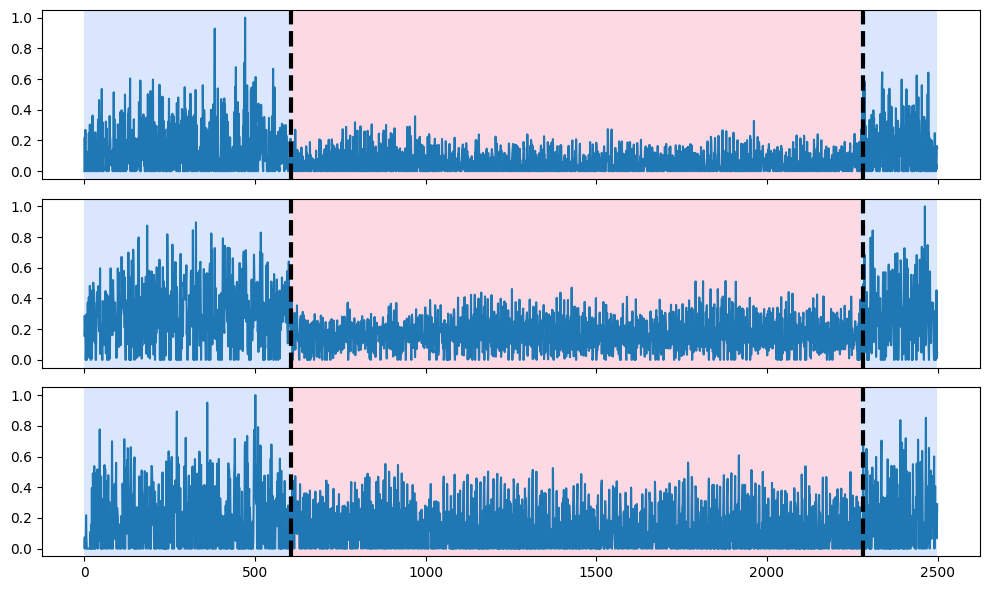

Signal n°  9
True segmentation : [1344 1656 1981 2395 2500]
Predicted segmentation : [1353 2500]
F1 score : 0.4


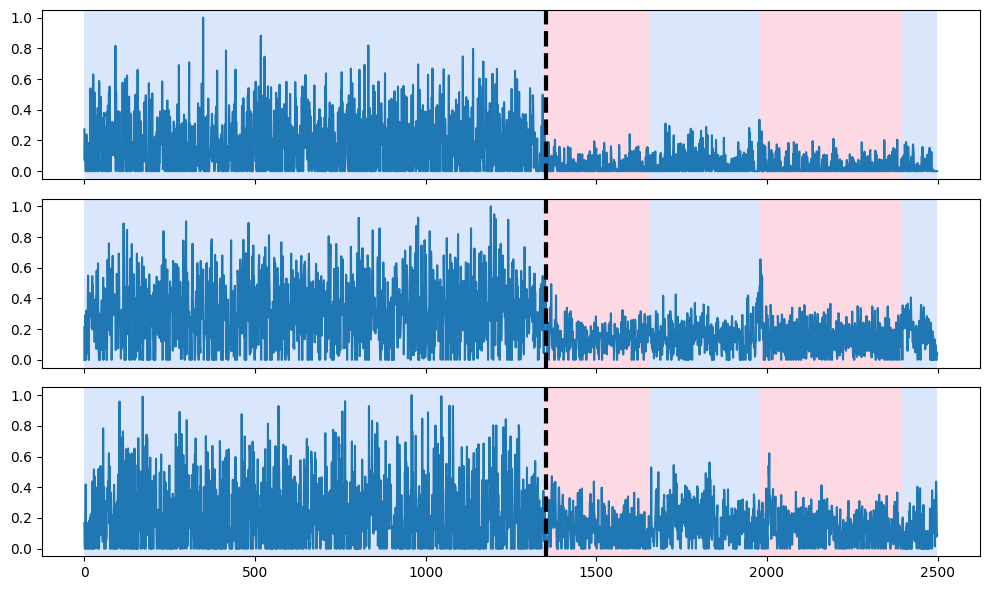

Signal n°  10
True segmentation : [ 700 2500]
Predicted segmentation : [ 699 2500]
F1 score : 1.0


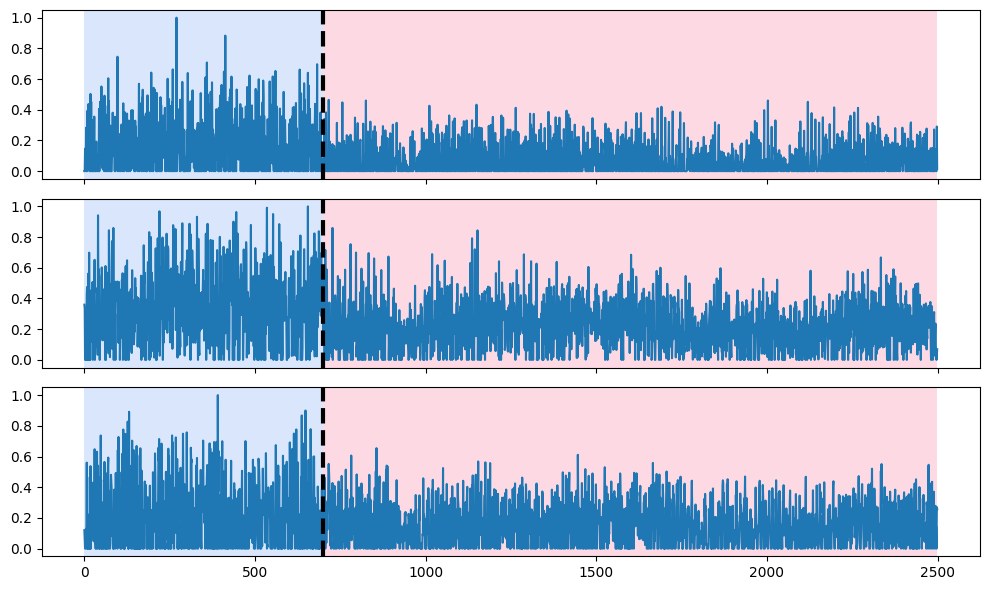

Signal n°  11
True segmentation : [ 454 2500]
Predicted segmentation : [ 474 2500]
F1 score : 1.0


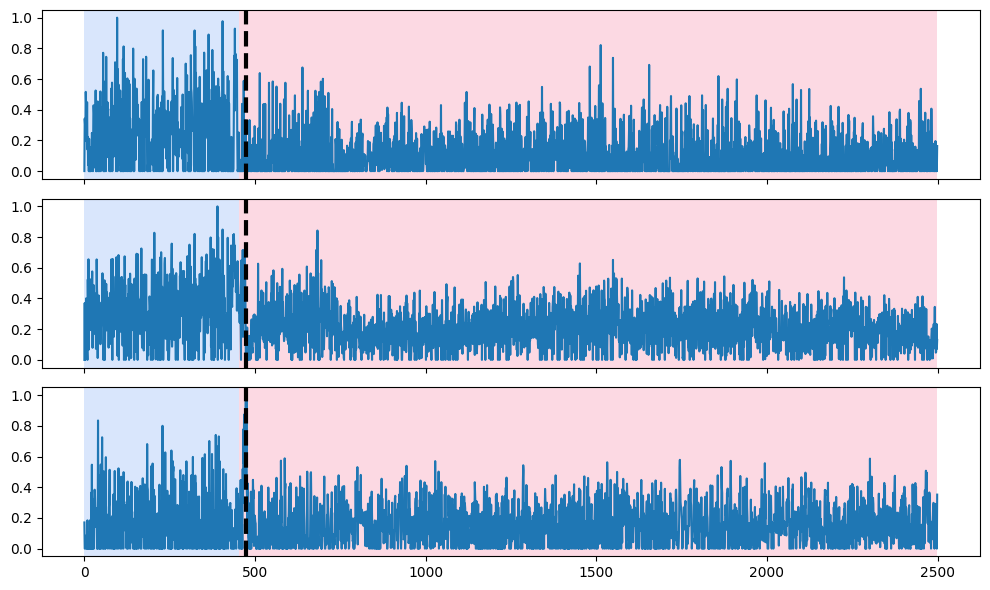

Signal n°  12
True segmentation : [1625 2500]
Predicted segmentation : [1629 2500]
F1 score : 1.0


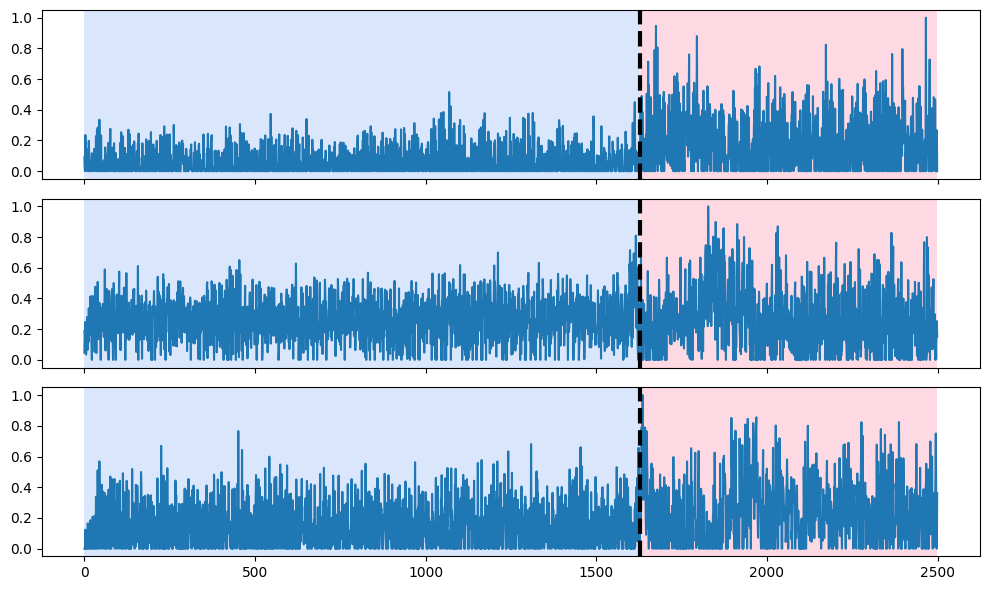

Signal n°  13
True segmentation : [ 646 2140 2500]
Predicted segmentation : [ 648 1238 2134 2500]
F1 score : 0.8


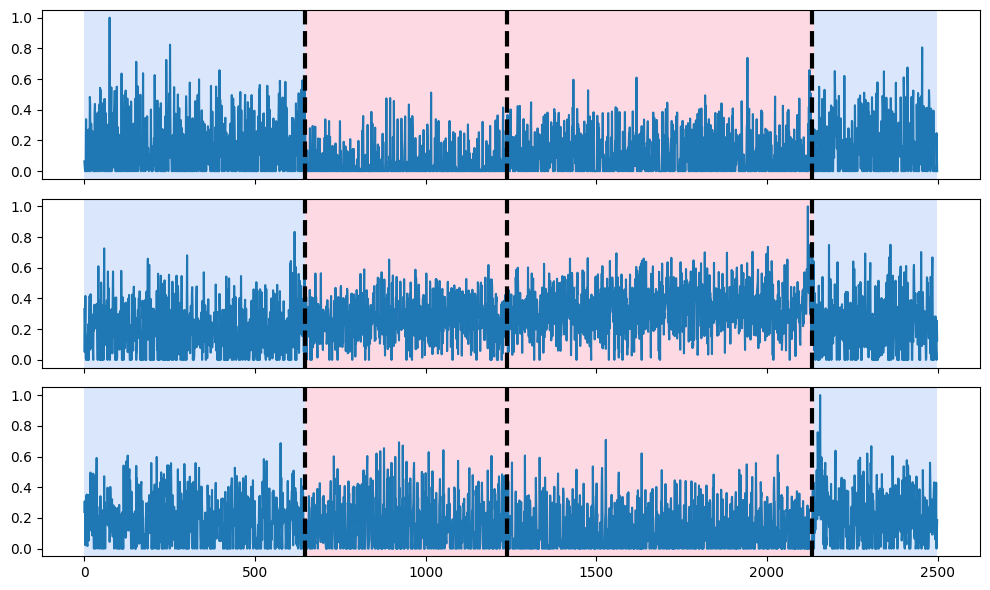

Signal n°  14
True segmentation : [1128 1341 1525 1720 1982 2195 2416 2500]
Predicted segmentation : [1306 1341 2500]
F1 score : 0.22222222222222224


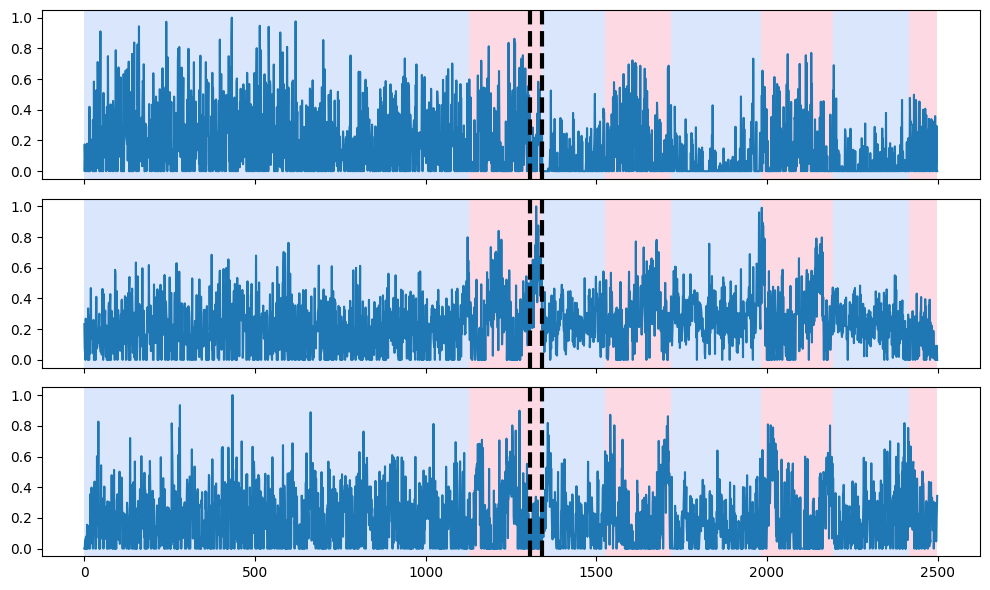

Signal n°  15
True segmentation : [1550 2500]
Predicted segmentation : [1543 2500]
F1 score : 1.0


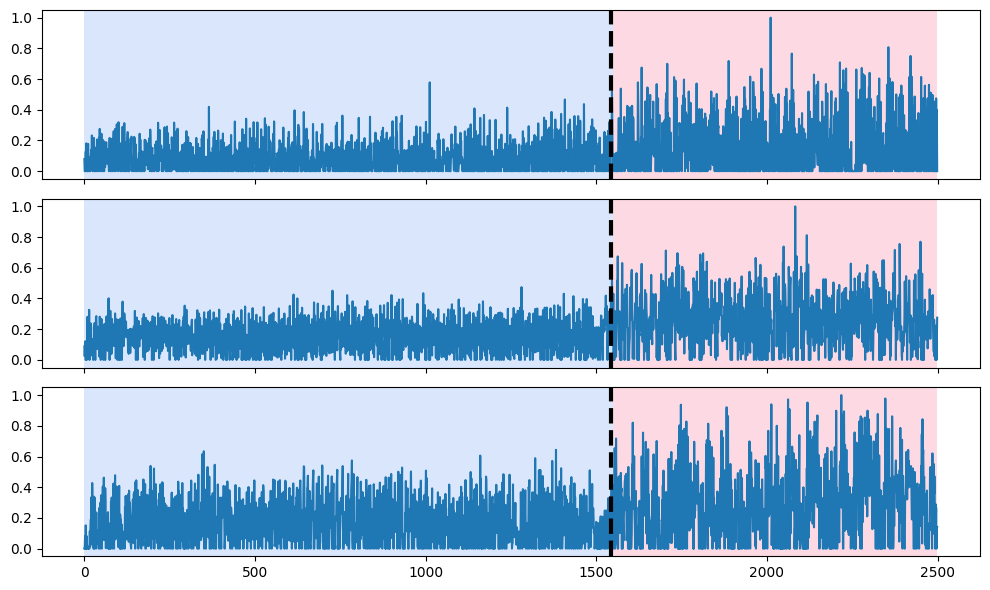

Signal n°  16
True segmentation : [2059 2414 2500]
Predicted segmentation : [2069 2500]
F1 score : 0.6666666666666666


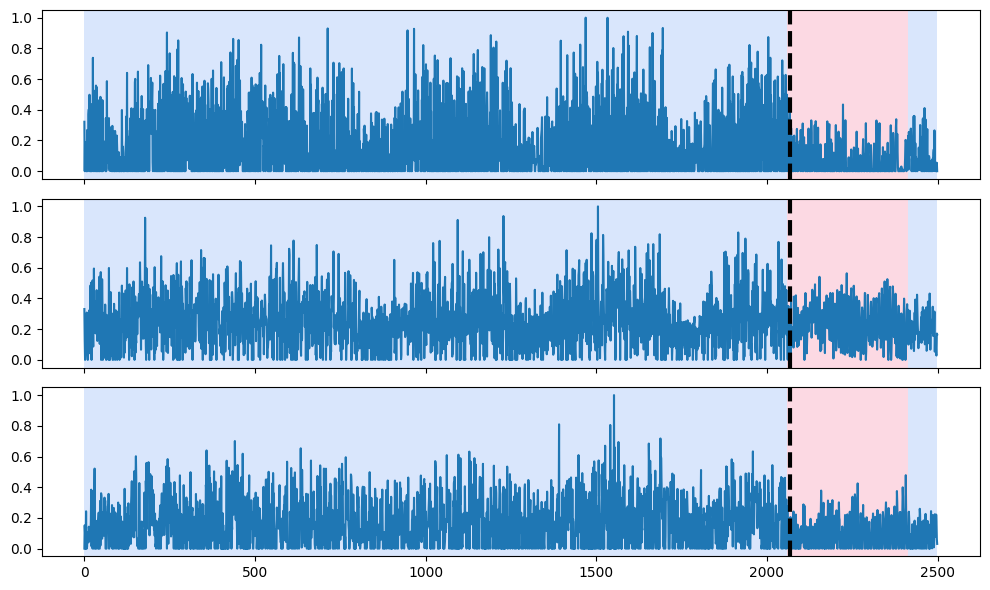

Signal n°  17
True segmentation : [ 172  519  783 1087 1337 1689 1959 2500]
Predicted segmentation : [1953 2500]
F1 score : 0.25


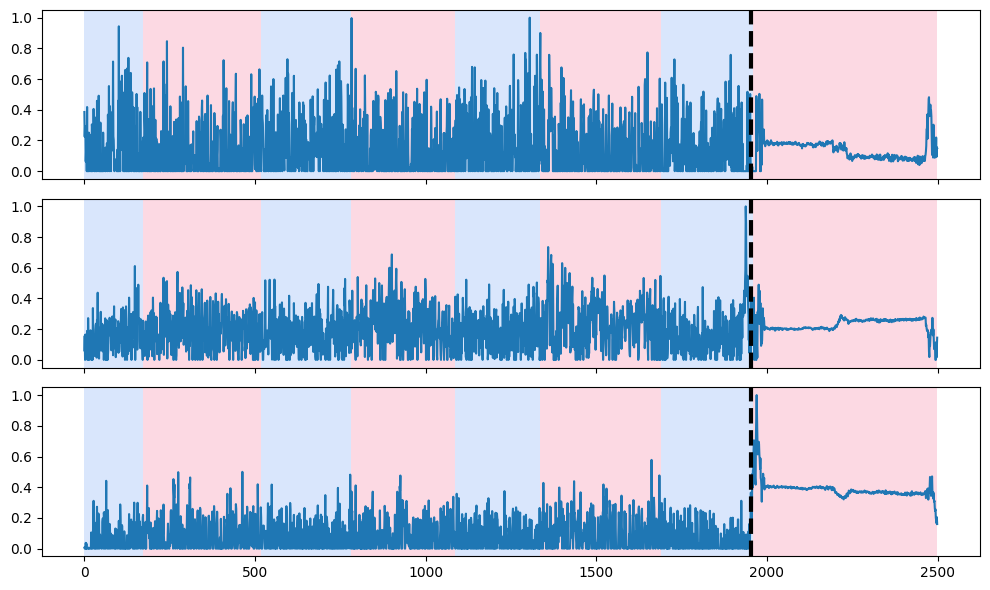

Signal n°  18
True segmentation : [1642 2500]
Predicted segmentation : [1667 2500]
F1 score : 1.0


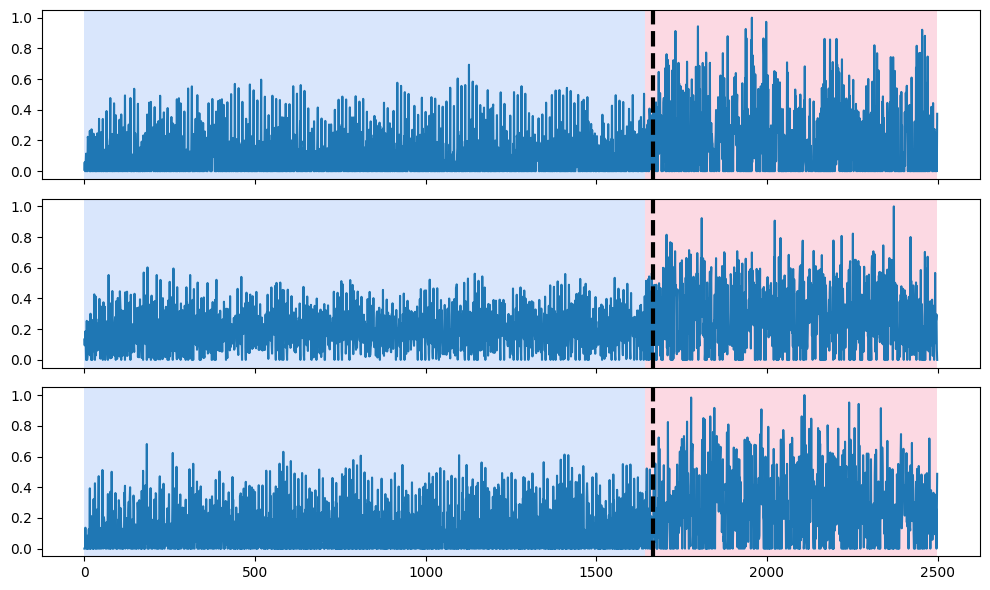

Signal n°  19
True segmentation : [ 664 2115 2500]
Predicted segmentation : [ 660 2125 2500]
F1 score : 1.0


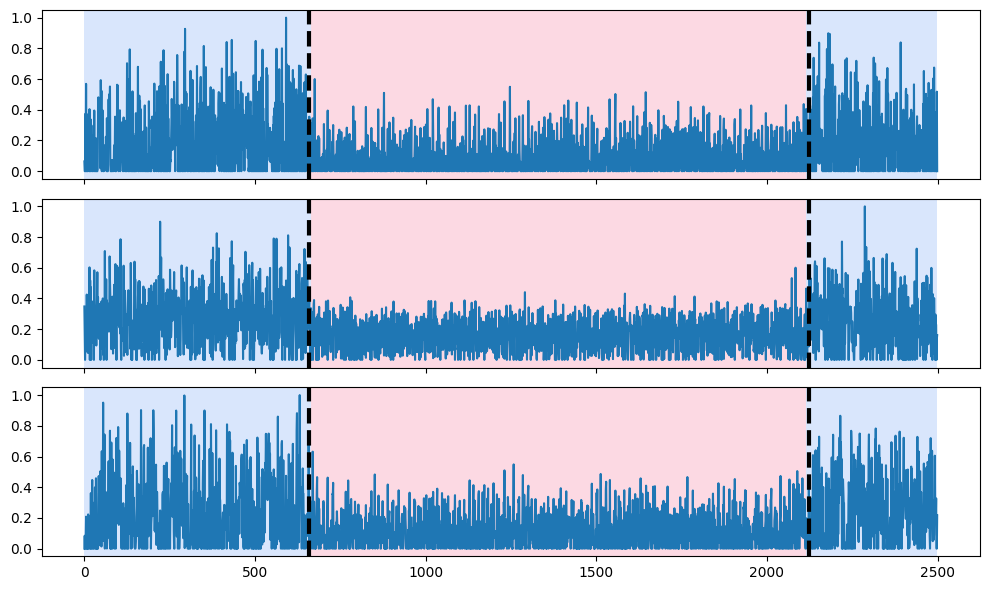

Signal n°  20
True segmentation : [1155 1406 1558 2028 2197 2429 2500]
Predicted segmentation : [1156 2198 2500]
F1 score : 0.5


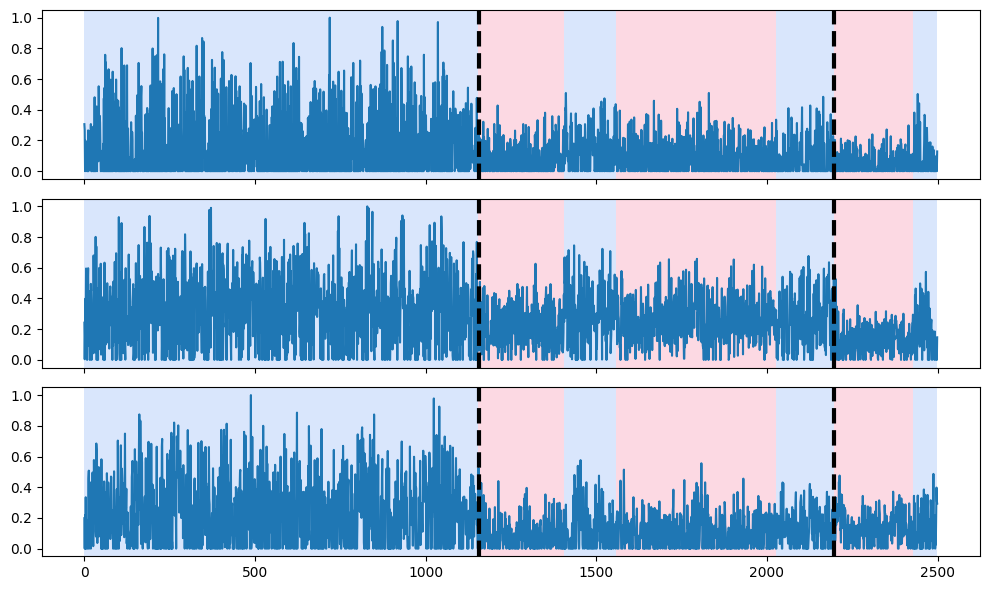

Signal n°  21
True segmentation : [ 564 2165 2441 2500]
Predicted segmentation : [ 583 2166 2500]
F1 score : 0.8


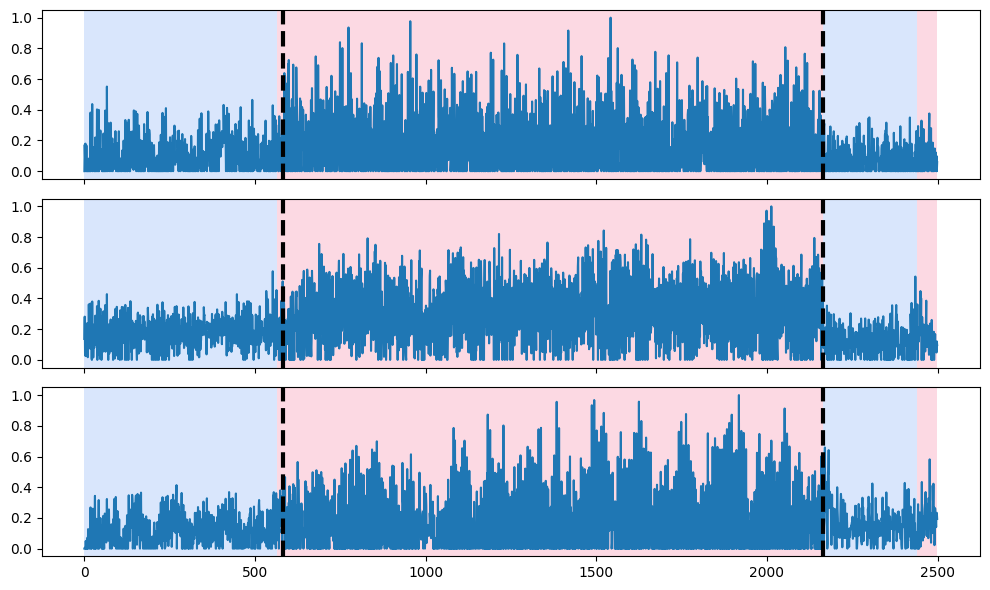

Signal n°  22
True segmentation : [1672 2500]
Predicted segmentation : [1673 2500]
F1 score : 1.0


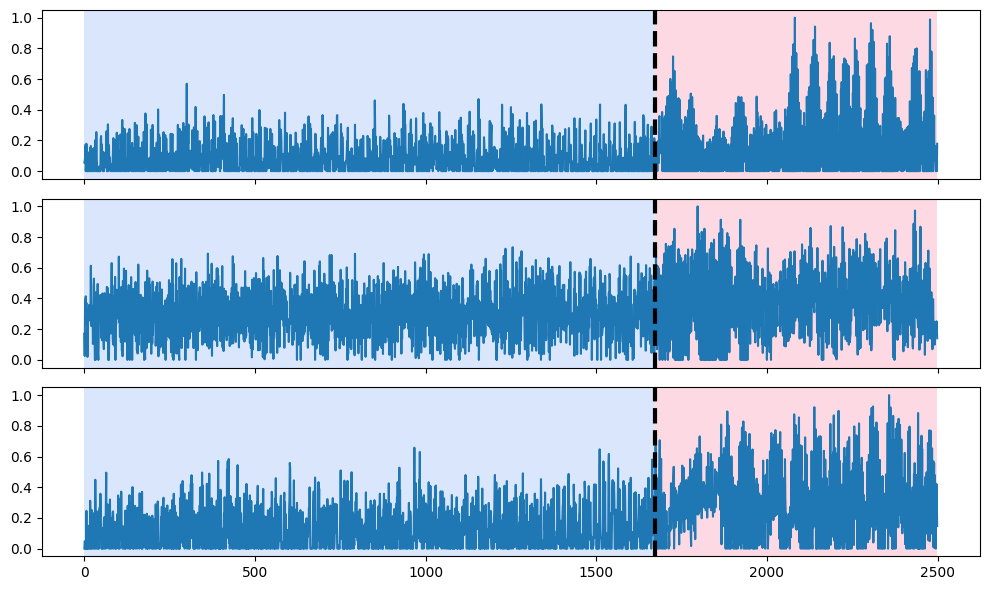

Signal n°  23
True segmentation : [ 662 2252 2500]
Predicted segmentation : [ 673 2252 2500]
F1 score : 1.0


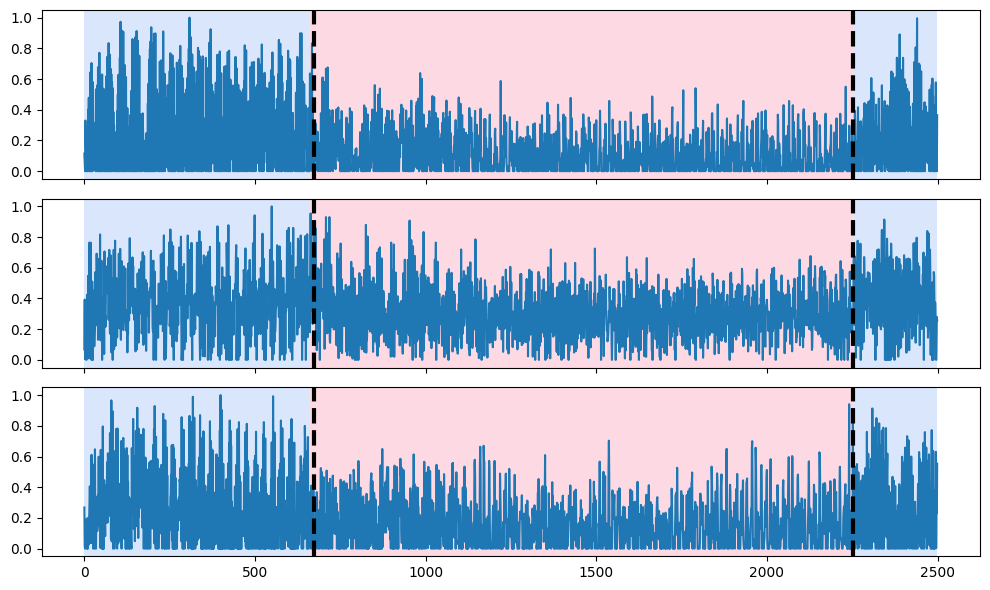

Signal n°  24
True segmentation : [1283 1546 1776 2038 2270 2500]
Predicted segmentation : [1280 2500]
F1 score : 0.33333333333333337


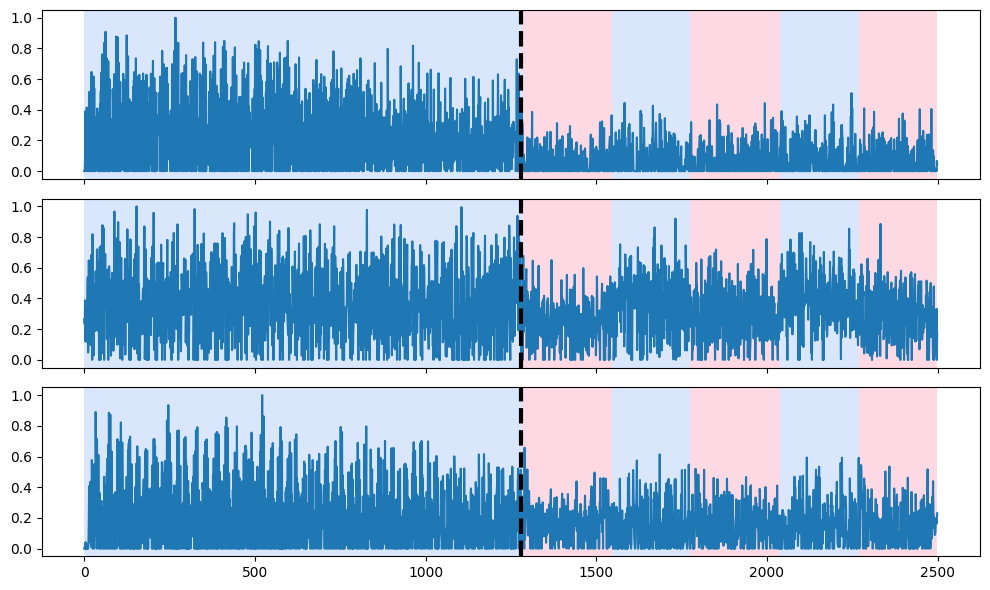

Signal n°  25
True segmentation : [1042 1460 1757 2062 2500]
Predicted segmentation : [1001 2500]
F1 score : 0.4


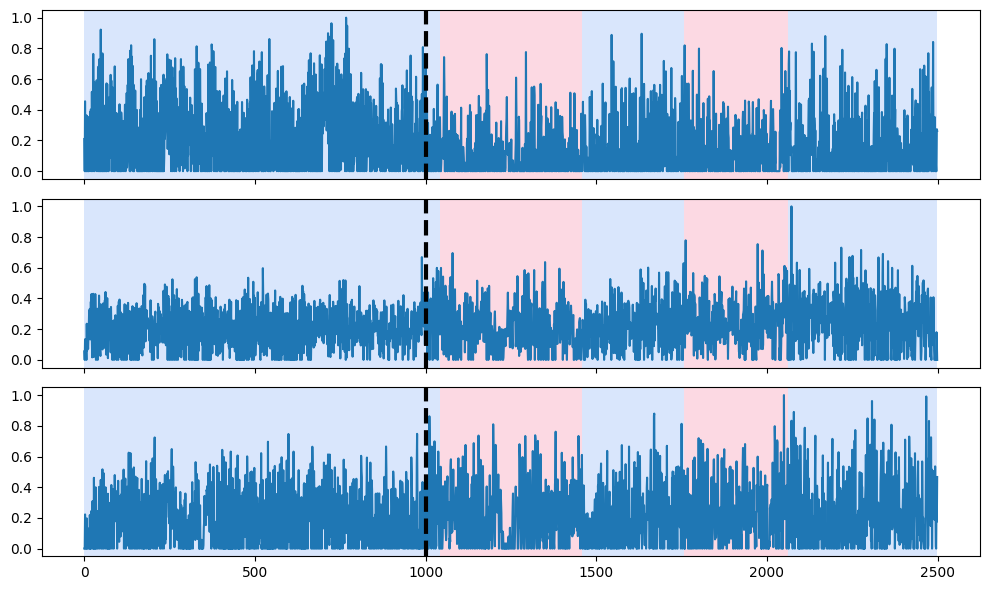

Signal n°  26
True segmentation : [1620 2500]
Predicted segmentation : [1610 2500]
F1 score : 1.0


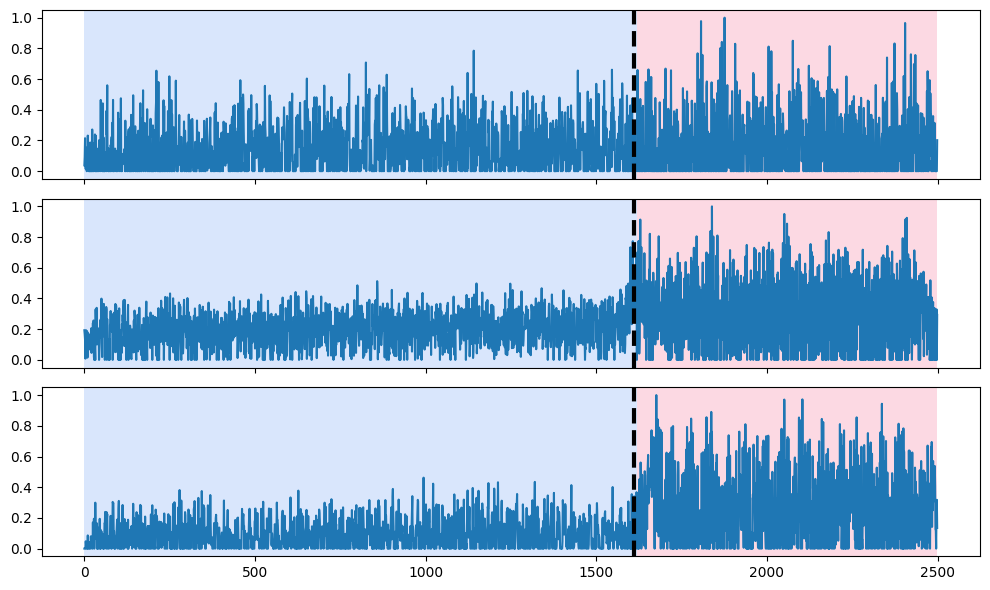

Signal n°  27
True segmentation : [ 573 2256 2500]
Predicted segmentation : [ 573 2256 2500]
F1 score : 1.0


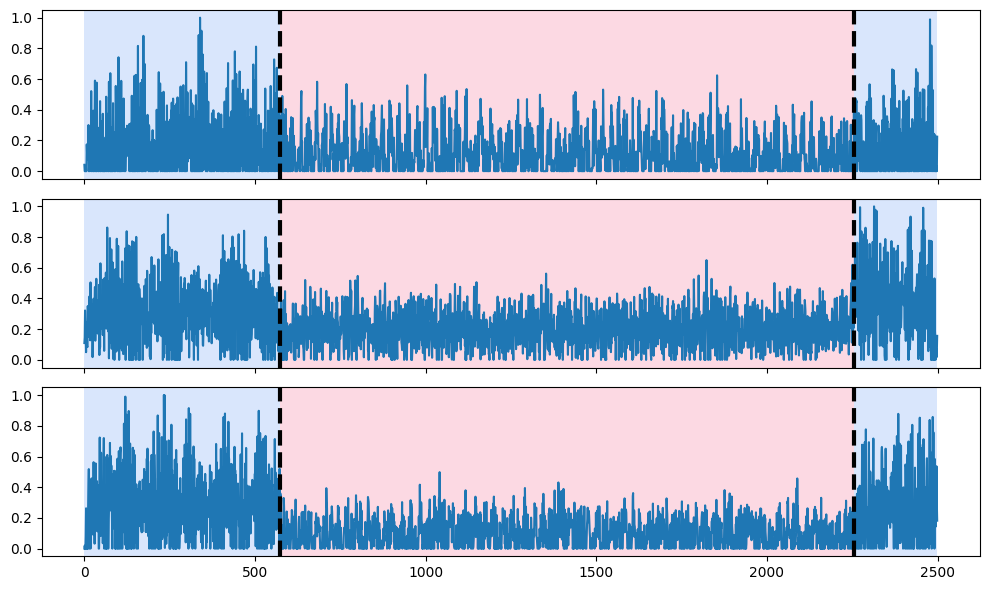

Signal n°  28
True segmentation : [1280 1510 1755 1967 2205 2432 2500]
Predicted segmentation : [1287 2208 2500]
F1 score : 0.5


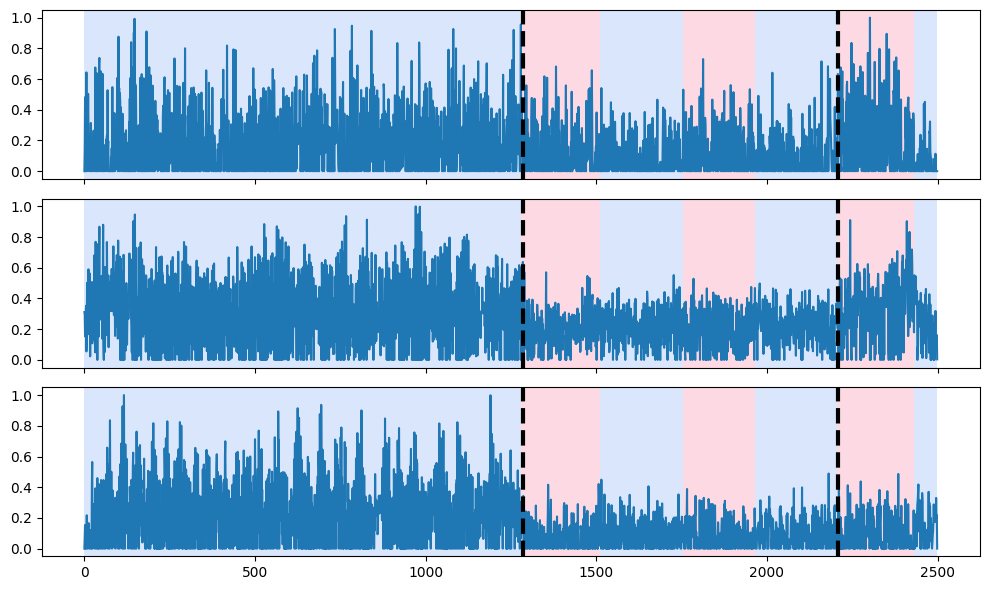

Signal n°  29
True segmentation : [ 488 2264 2494 2500]
Predicted segmentation : [ 482 2256 2500]
F1 score : 0.8


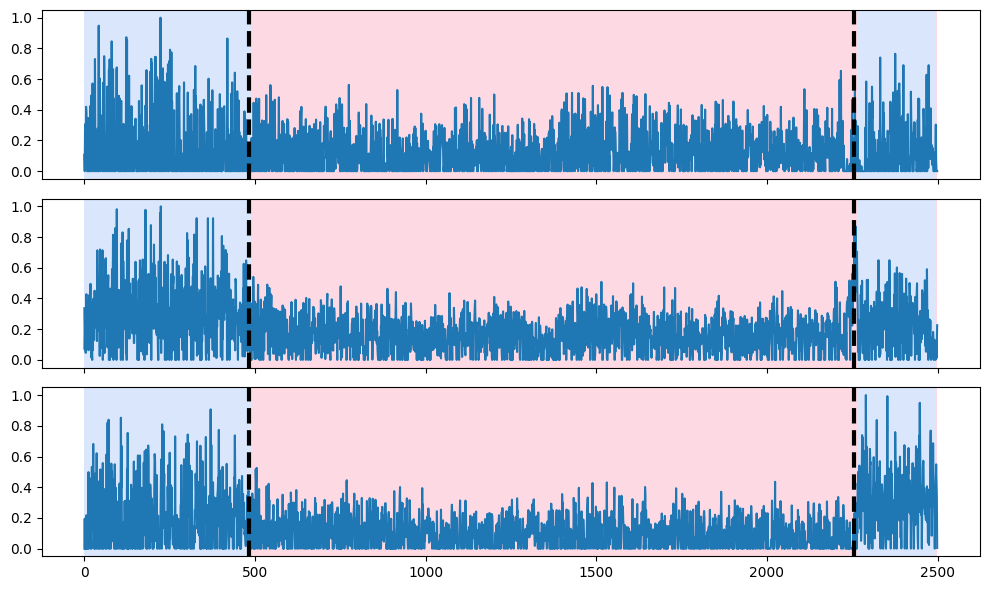

Signal n°  30
True segmentation : [ 145 1721 2500]
Predicted segmentation : [ 144 1718 2500]
F1 score : 1.0


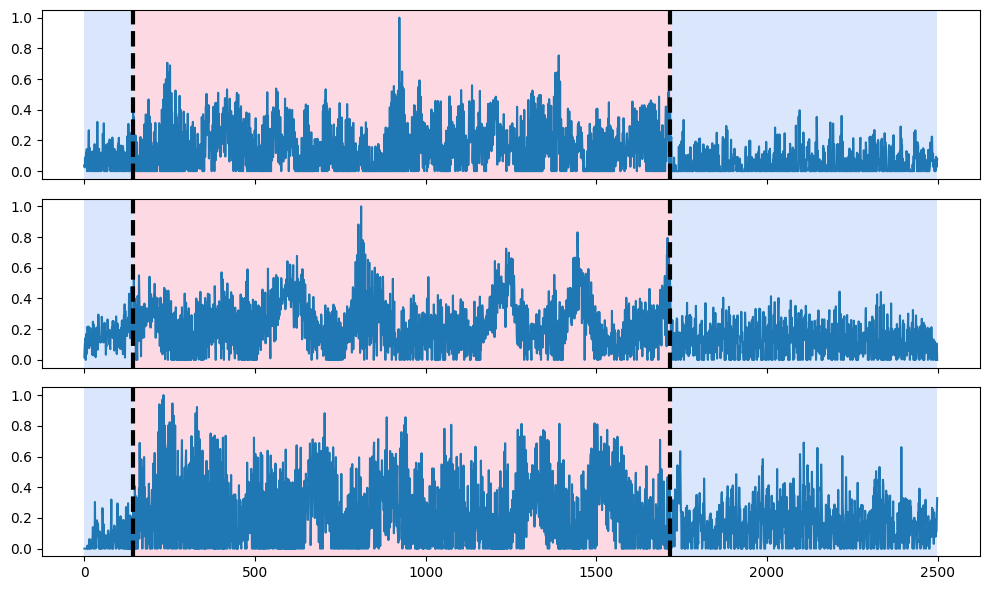

Signal n°  31
True segmentation : [ 640 2133 2276 2475 2500]
Predicted segmentation : [ 637 1981 2500]
F1 score : 0.3333333333333333


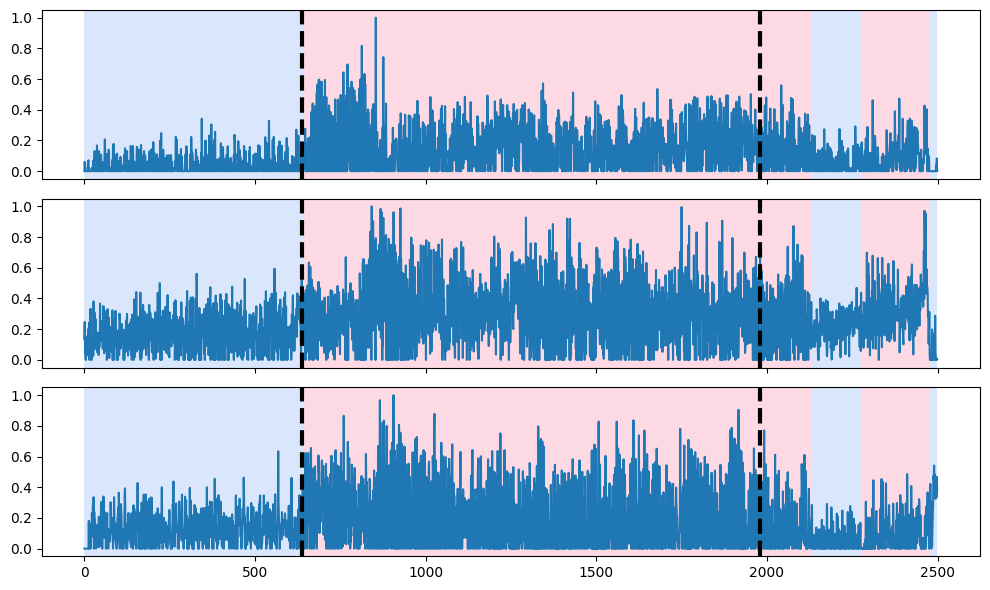

Signal n°  32
True segmentation : [1399 2500]
Predicted segmentation : [1402 2500]
F1 score : 1.0


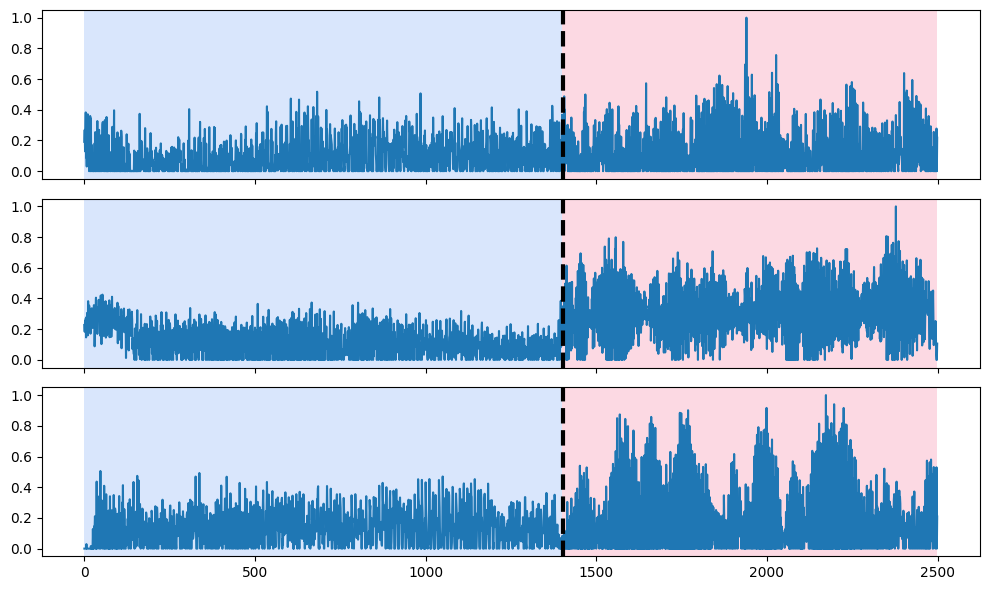

Signal n°  33
True segmentation : [ 496 1795 2500]
Predicted segmentation : [ 479 1797 2500]
F1 score : 1.0


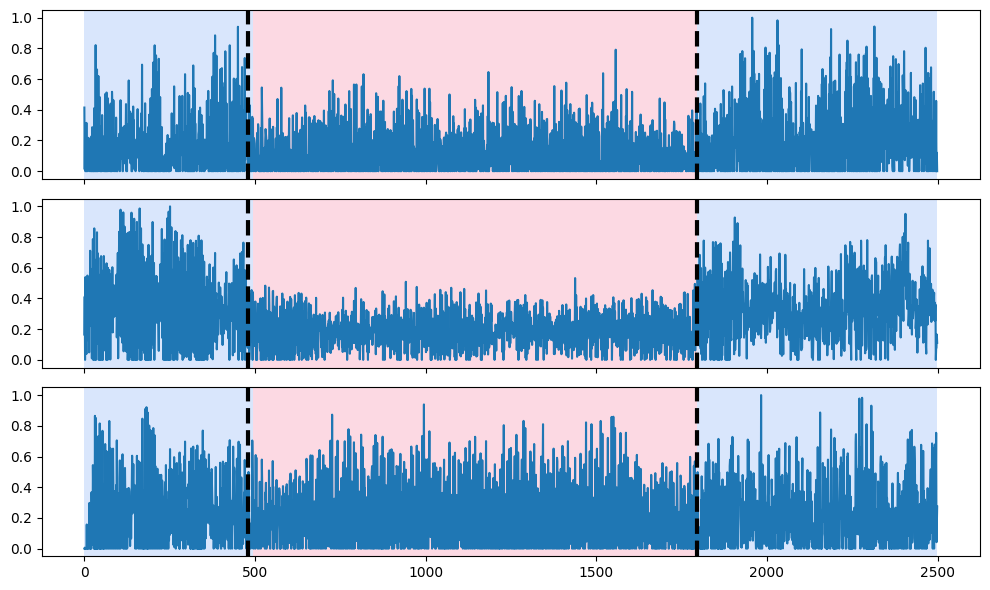

Signal n°  34
True segmentation : [ 789 1361 1558 1725 1901 2080 2241 2430 2500]
Predicted segmentation : [ 795 1333 1361 2414 2500]
F1 score : 0.5


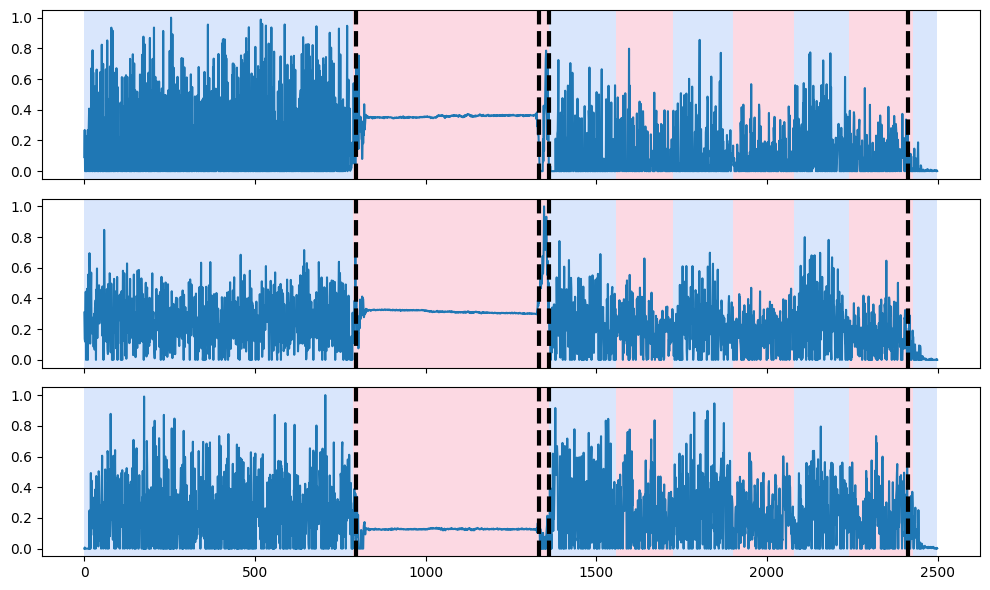

Signal n°  35
True segmentation : [1647 2500]
Predicted segmentation : [1640 2500]
F1 score : 1.0


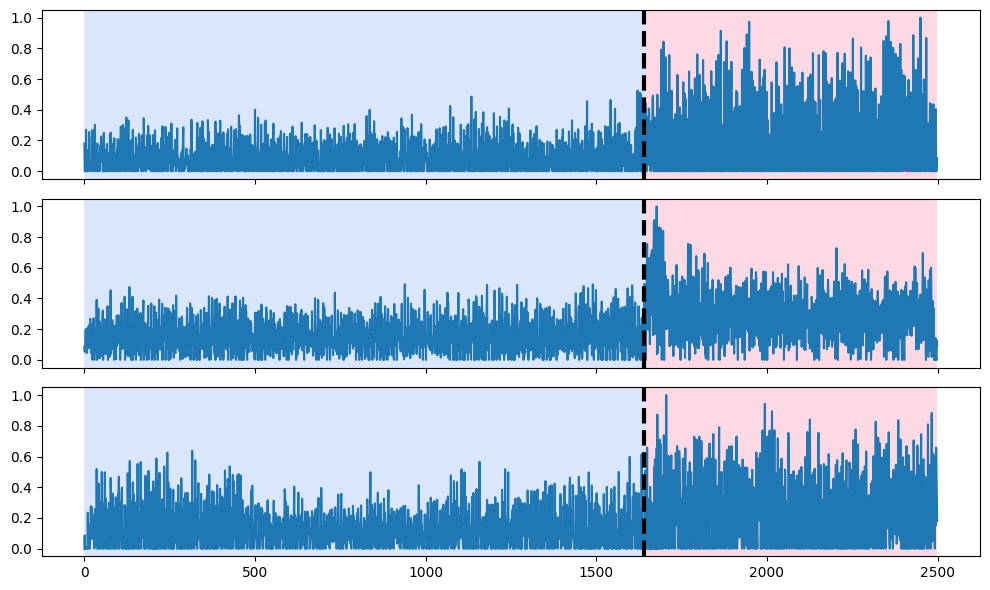

Signal n°  36
True segmentation : [2224 2500]
Predicted segmentation : [2206 2500]
F1 score : 1.0


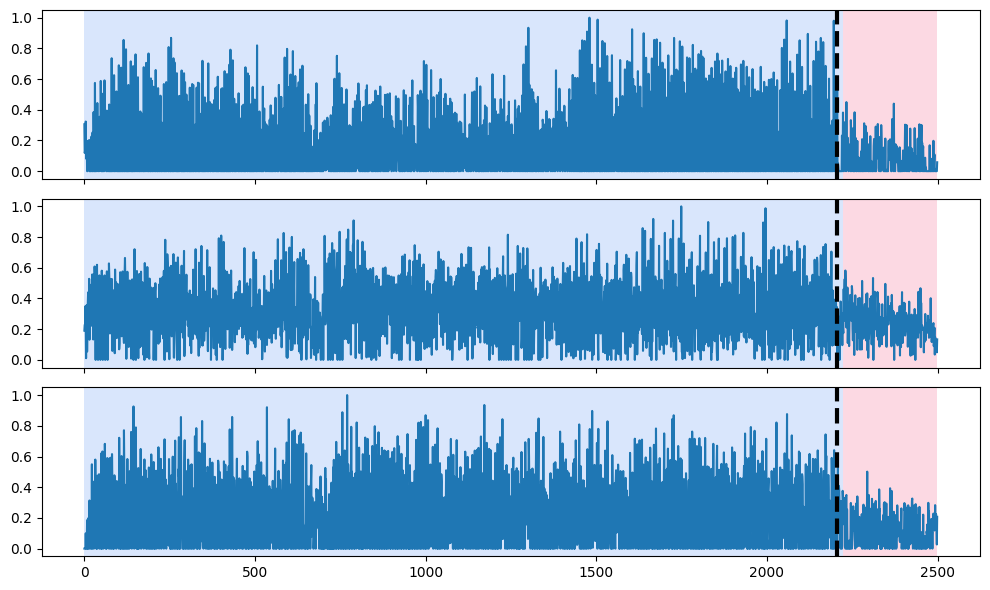

Signal n°  37
True segmentation : [1519 1743 1973 2001 2211 2500]
Predicted segmentation : [1519 1742 2500]
F1 score : 0.5714285714285715


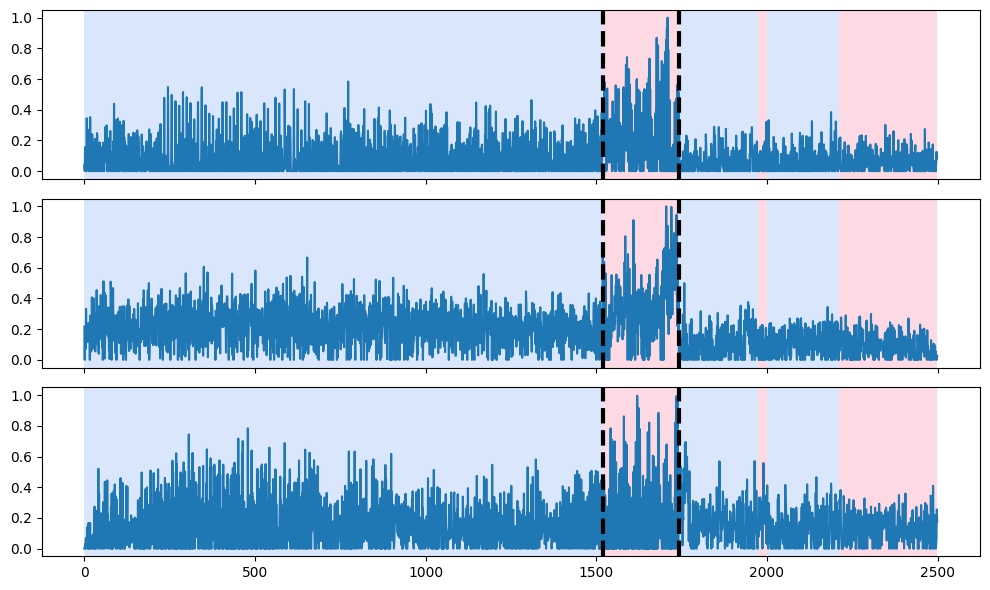

Signal n°  38
True segmentation : [ 644 1009 1315 1630 1955 2332 2500]
Predicted segmentation : [ 655  997 2500]
F1 score : 0.5


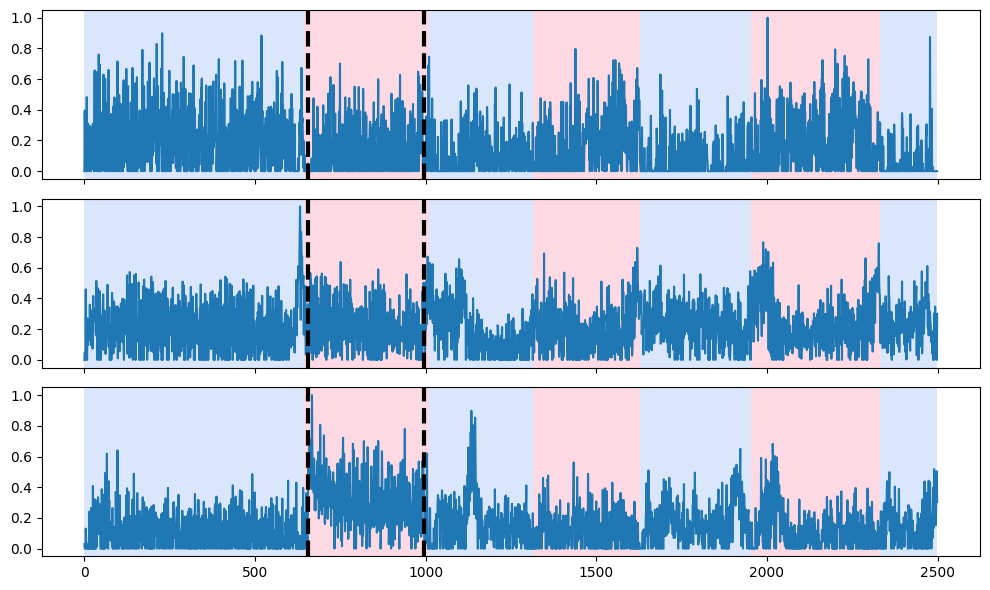

Signal n°  39
True segmentation : [1699 2500]
Predicted segmentation : [1714 2500]
F1 score : 1.0


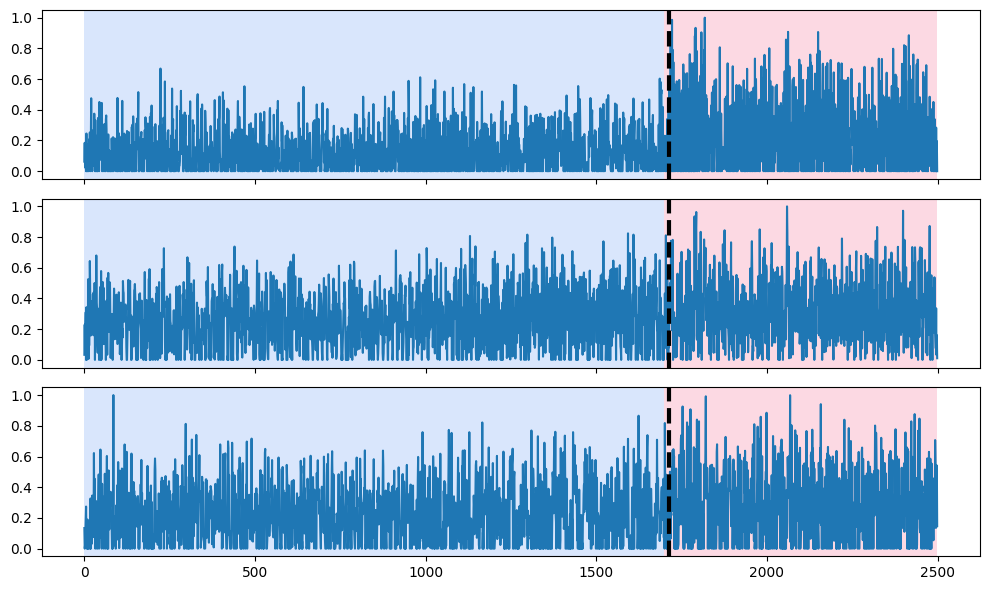

Signal n°  40
True segmentation : [ 774 2419 2500]
Predicted segmentation : [ 764 2500]
F1 score : 0.6666666666666666


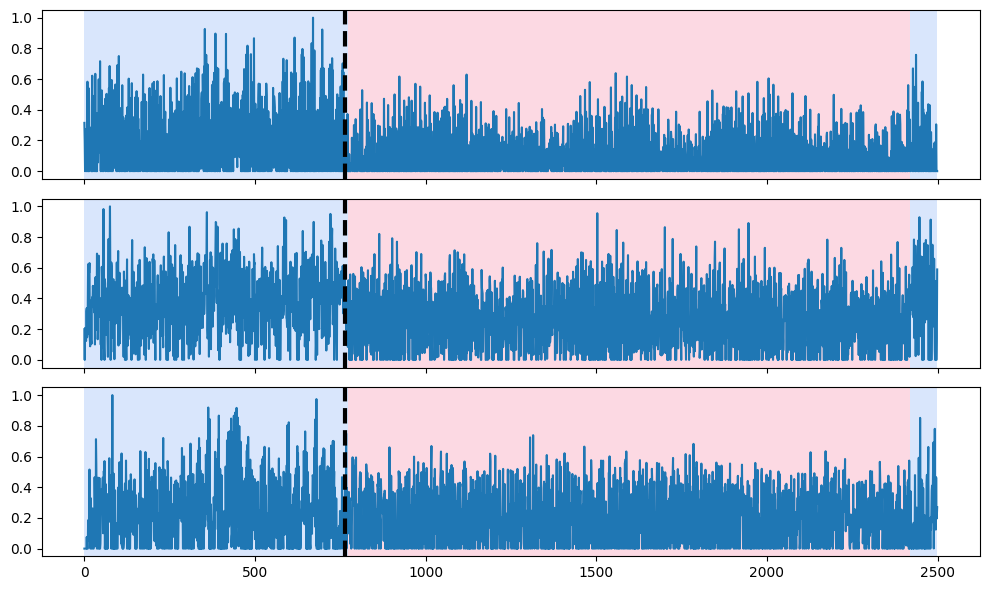

Signal n°  41
True segmentation : [1561 1899 2292 2500]
Predicted segmentation : [1557 1899 2287 2500]
F1 score : 1.0


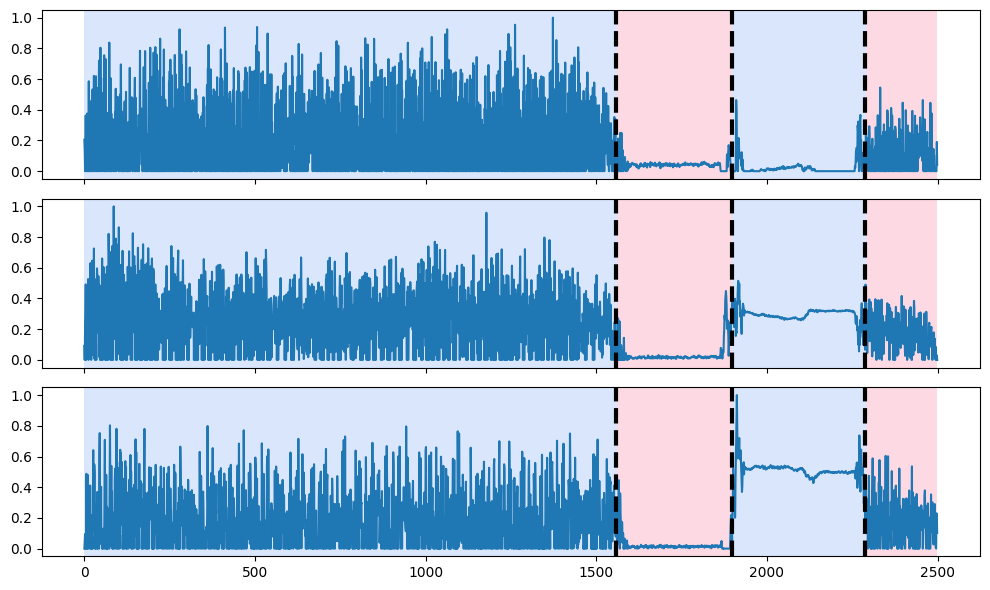

Signal n°  42
True segmentation : [ 224 1527 2500]
Predicted segmentation : [ 238 1532 2500]
F1 score : 1.0


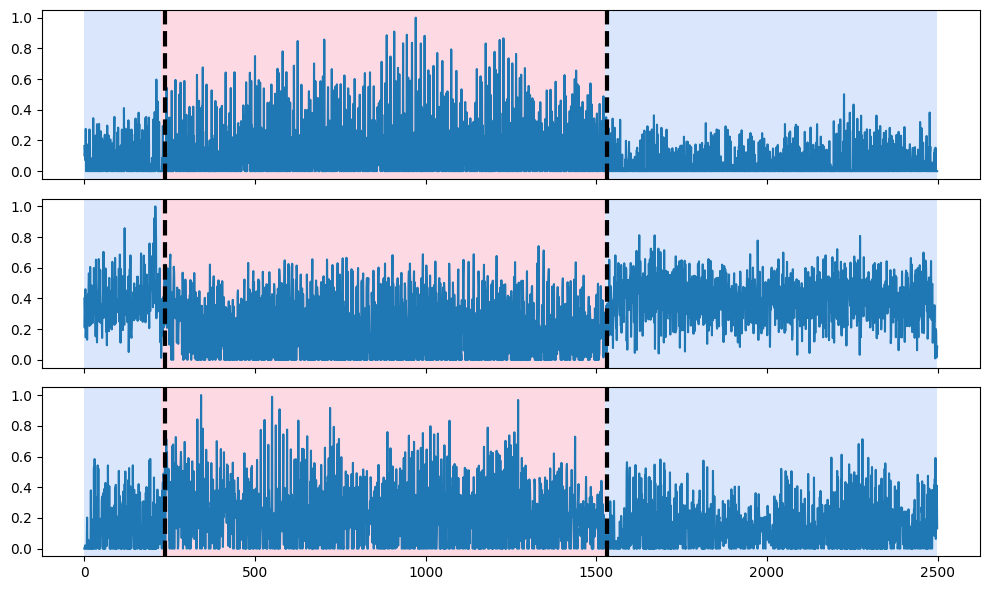

Signal n°  43
True segmentation : [ 579 1855 2147 2454 2500]
Predicted segmentation : [ 570 1855 2500]
F1 score : 0.6666666666666666


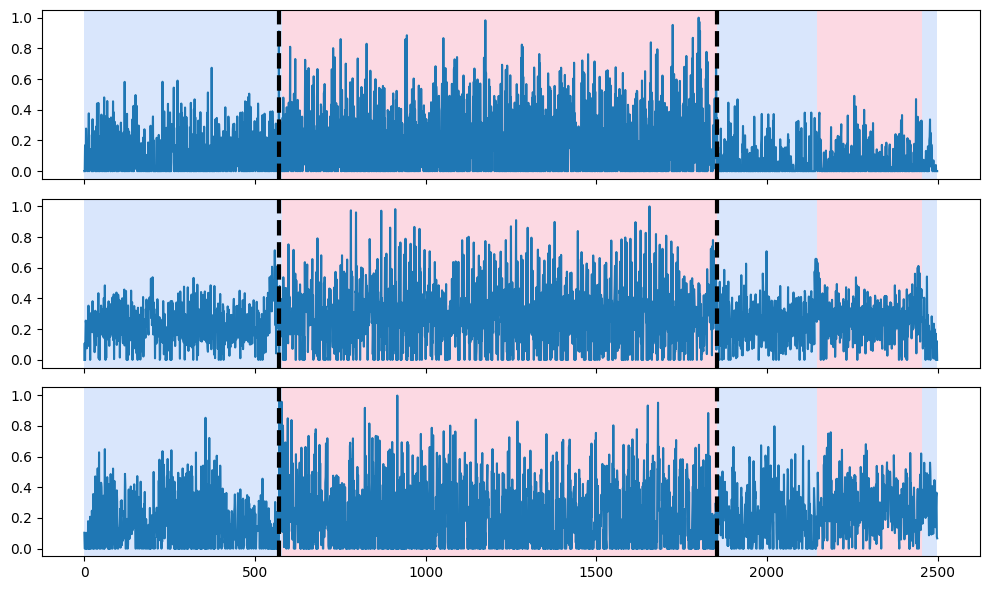

Signal n°  44
True segmentation : [ 239  504  828 1092 1305 1979 2500]
Predicted segmentation : [ 863 1081 1275 1978 2500]
F1 score : 0.8


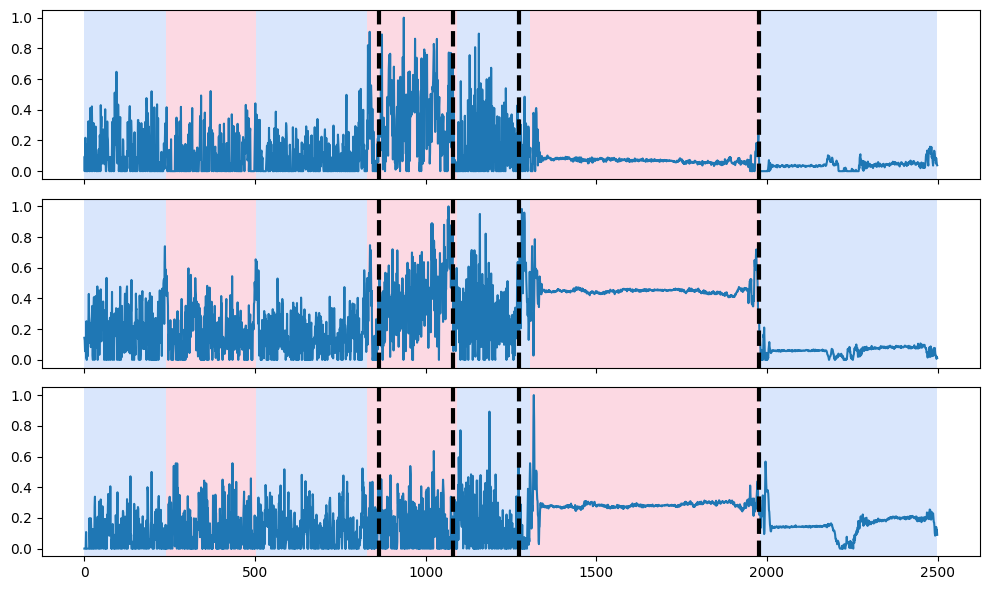

Signal n°  45
True segmentation : [2464 2500]
Predicted segmentation : [2465 2500]
F1 score : 1.0


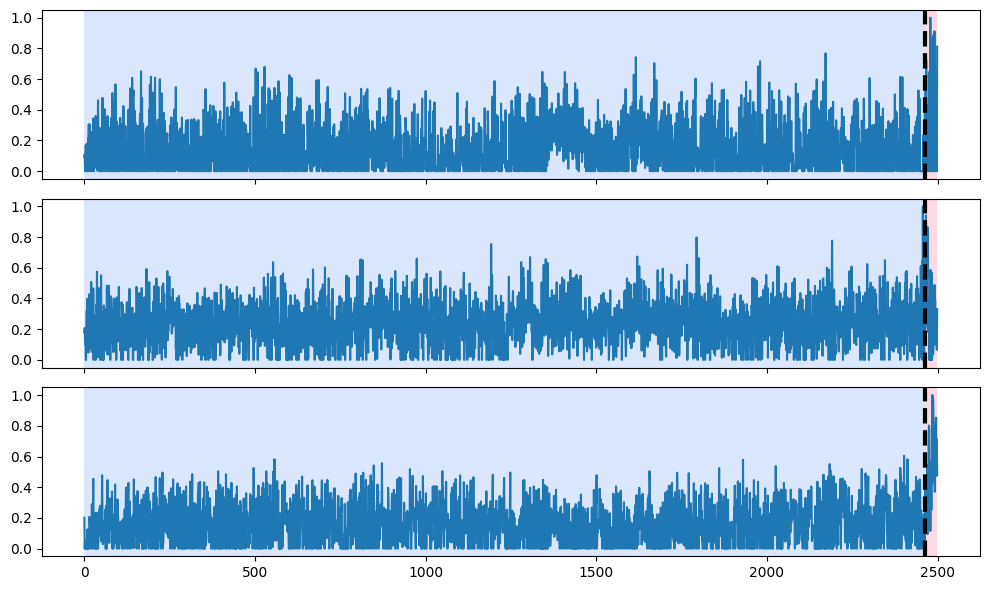

Signal n°  46
True segmentation : [1680 2500]
Predicted segmentation : [1671 2500]
F1 score : 1.0


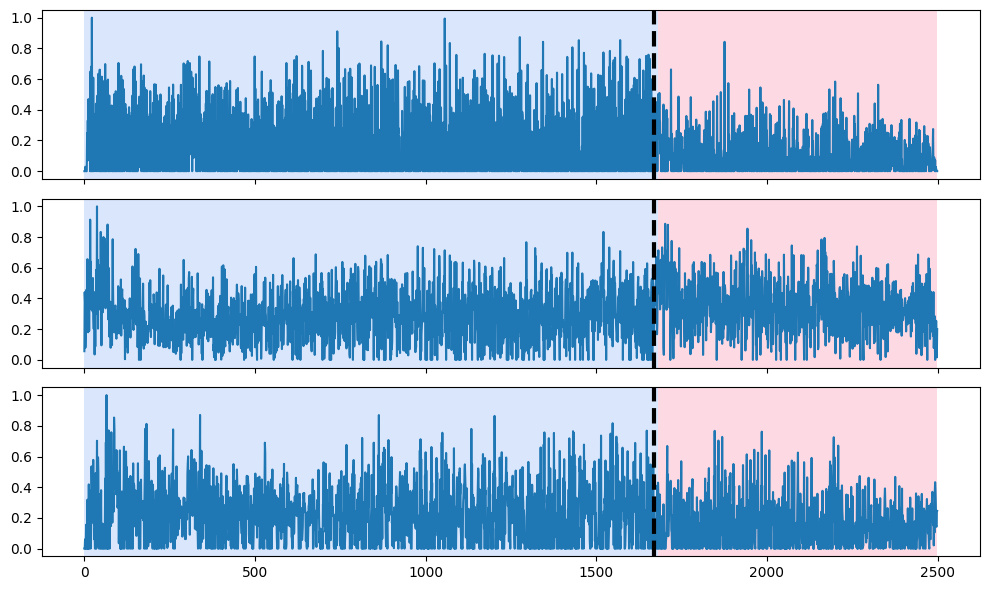

Signal n°  47
True segmentation : [ 934 2500]
Predicted segmentation : [ 938 2500]
F1 score : 1.0


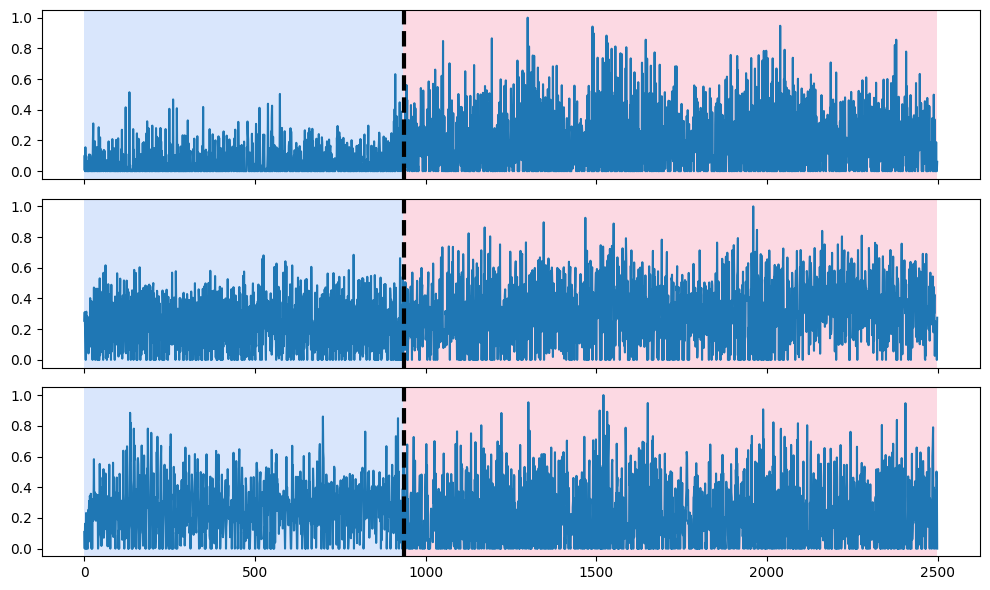

Signal n°  48
True segmentation : [ 237  618  940 1324 1658 2062 2380 2500]
Predicted segmentation : [ 242  264 2061 2383 2500]
F1 score : 0.5454545454545454


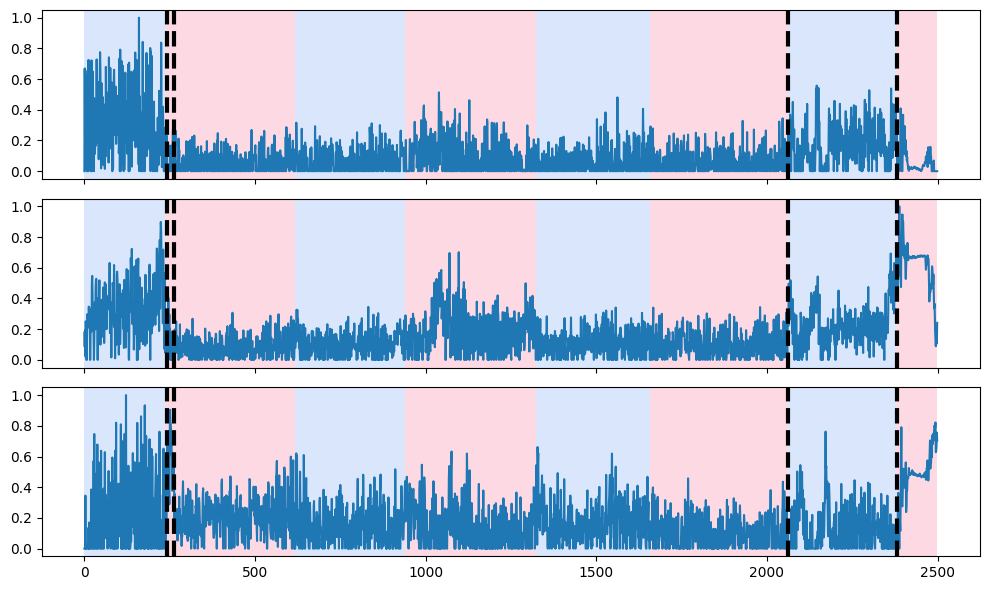

Signal n°  49
True segmentation : [1623 2500]
Predicted segmentation : [1634 2500]
F1 score : 1.0


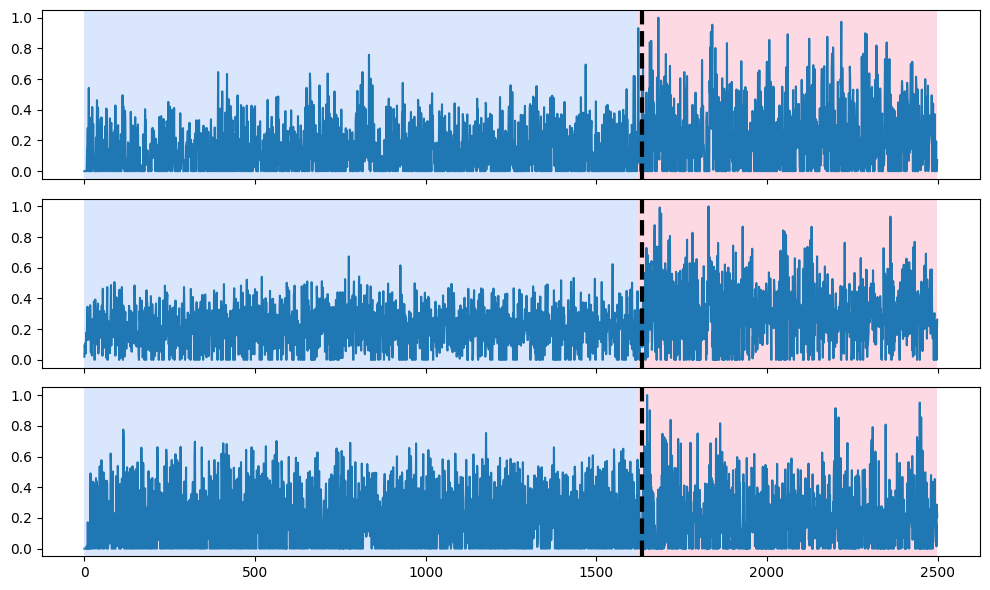

Signal n°  50
True segmentation : [  89  491 1206 1468 1698 1968 2189 2500]
Predicted segmentation : [  88  492 1206 2301 2500]
F1 score : 0.7272727272727273


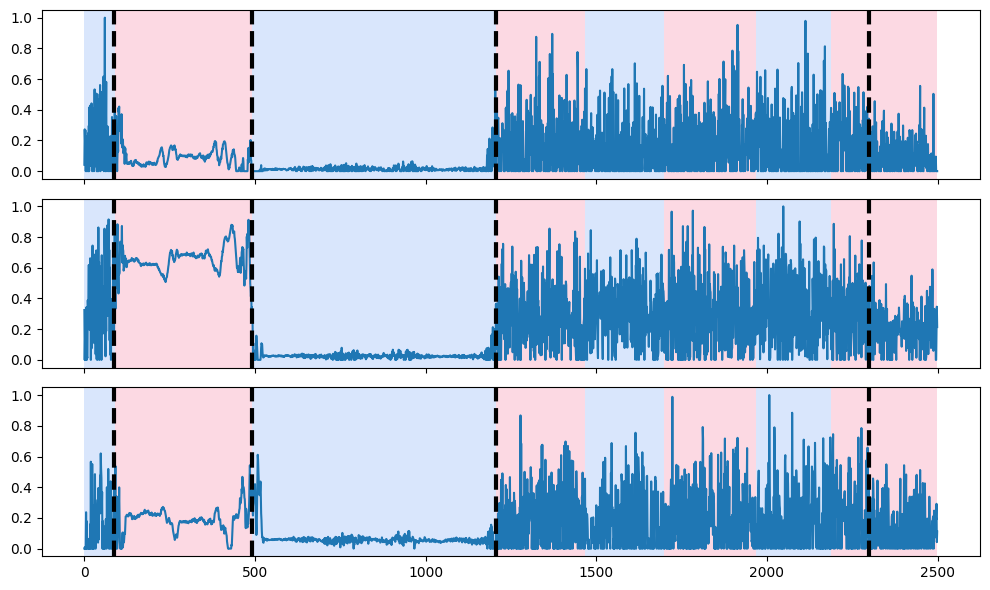

Signal n°  51
True segmentation : [1686 2500]
Predicted segmentation : [1688 2500]
F1 score : 1.0


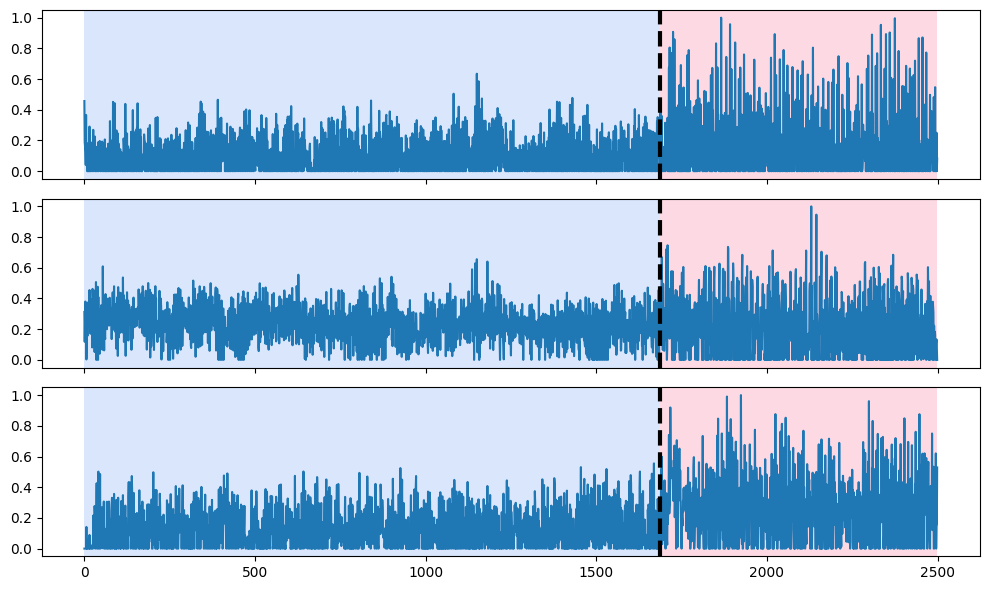

Signal n°  52
True segmentation : [1010 2500]
Predicted segmentation : [1009 2500]
F1 score : 1.0


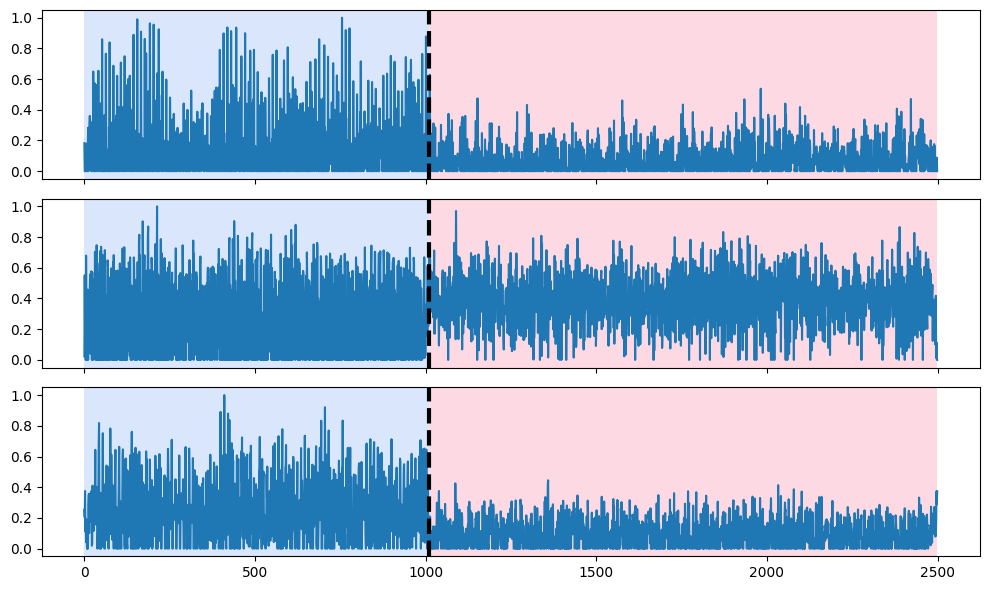

Signal n°  53
True segmentation : [  68  997 1400 2106 2337 2500]
Predicted segmentation : [  68 1000 1401 2108 2334 2500]
F1 score : 1.0


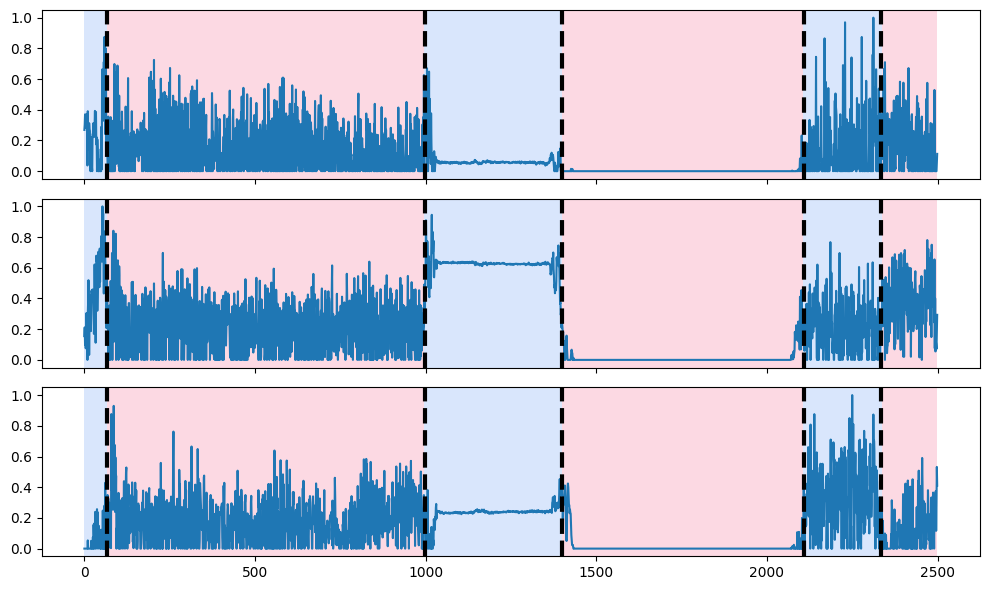

Signal n°  54
True segmentation : [ 336  626  987 1315 1671 1996 2364 2500]
Predicted segmentation : [ 357 1345 1678 2001 2354 2500]
F1 score : 0.8333333333333333


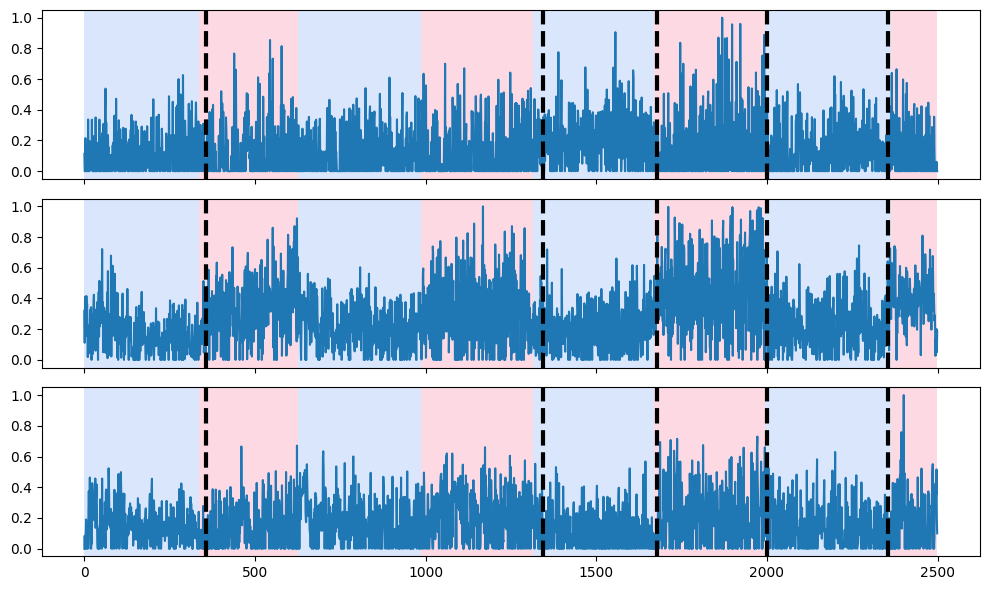

Signal n°  55
True segmentation : [1757 2500]
Predicted segmentation : [1755 2500]
F1 score : 1.0


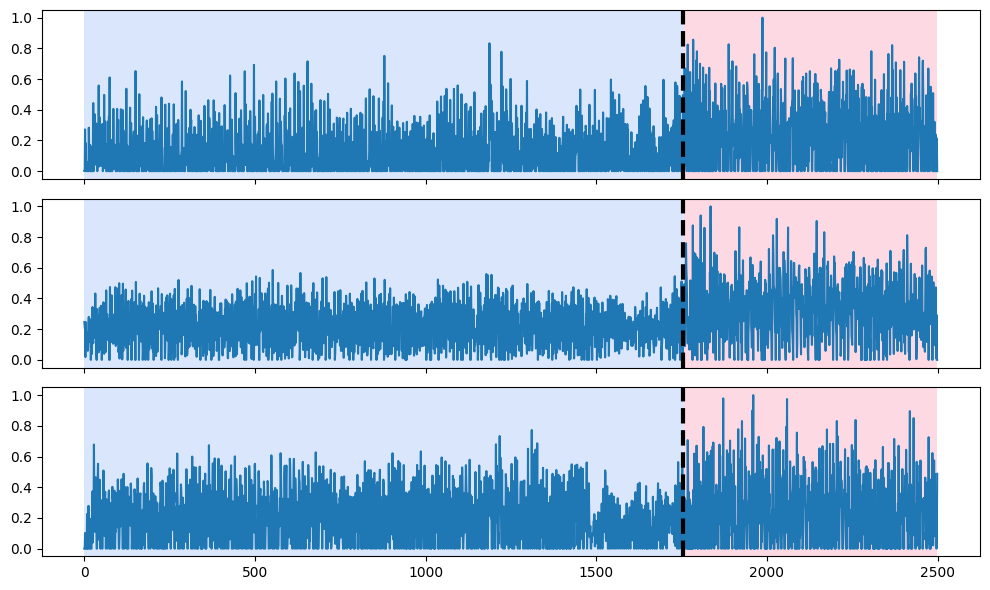

Signal n°  56
True segmentation : [ 813 1490 1790 2140 2420 2500]
Predicted segmentation : [ 810 2500]
F1 score : 0.33333333333333337


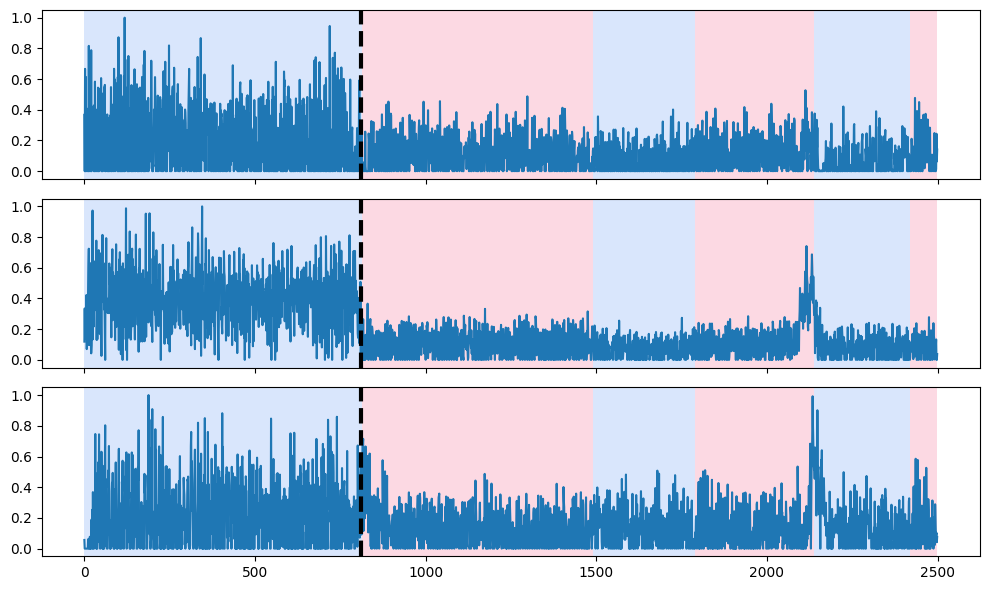

Signal n°  57
True segmentation : [1700 2500]
Predicted segmentation : [1704 2500]
F1 score : 1.0


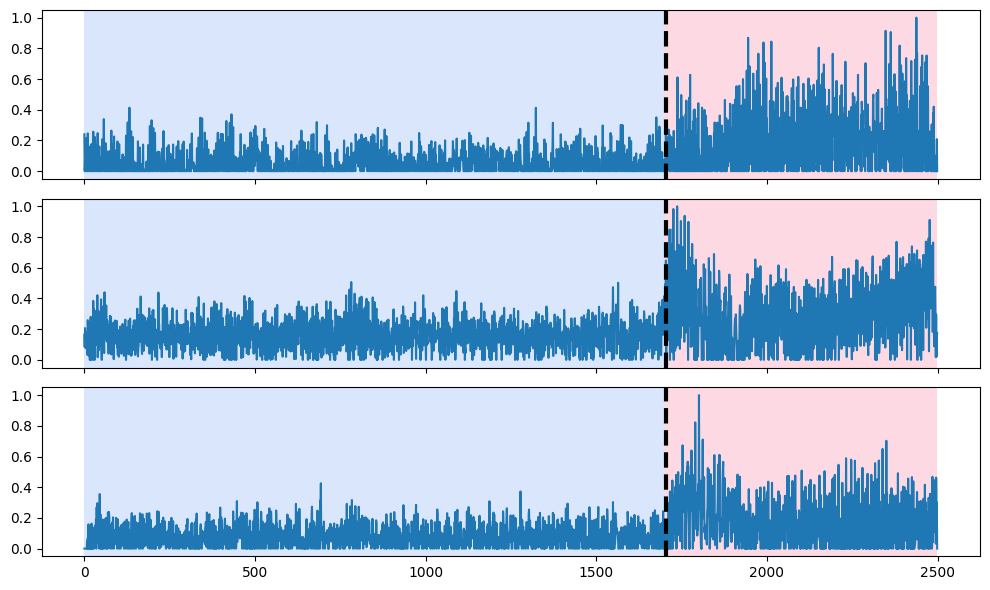

Signal n°  58
True segmentation : [ 450 1965 2500]
Predicted segmentation : [ 447 1968 2500]
F1 score : 1.0


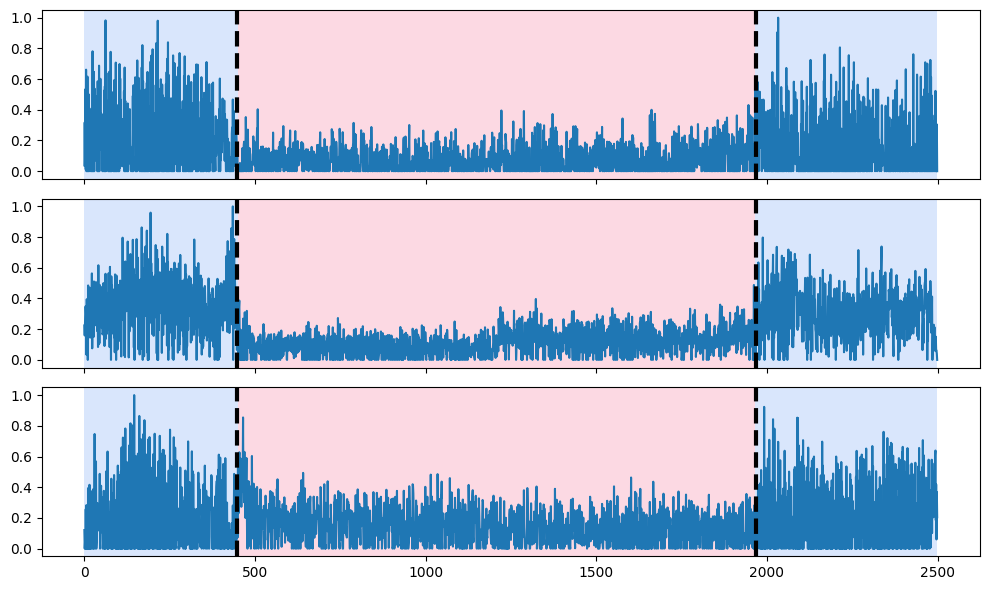

Signal n°  59
True segmentation : [1570 2500]
Predicted segmentation : [1564 2500]
F1 score : 1.0


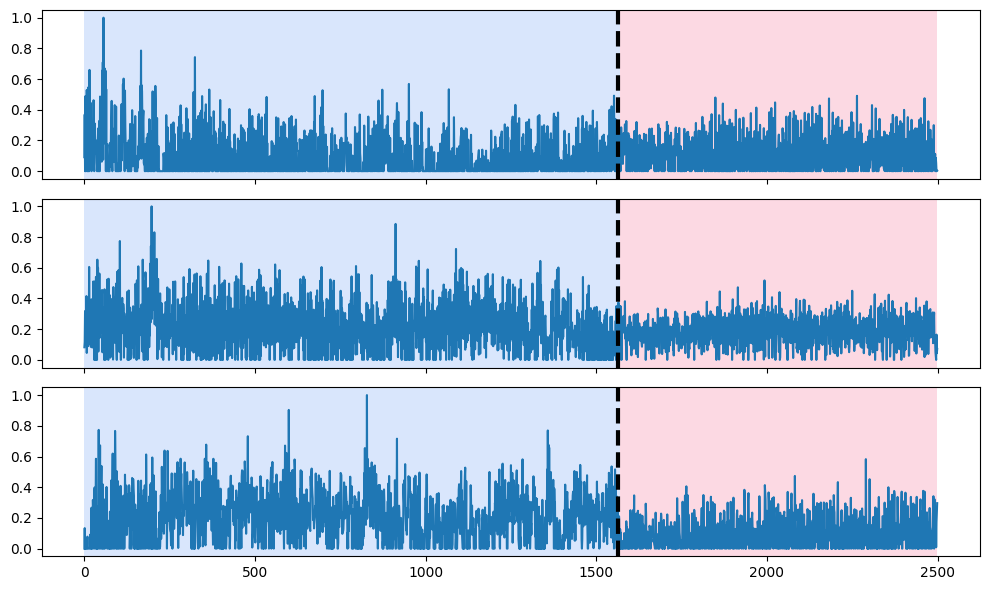

Signal n°  60
True segmentation : [ 463 1189 2500]
Predicted segmentation : [ 471 1180 2500]
F1 score : 1.0


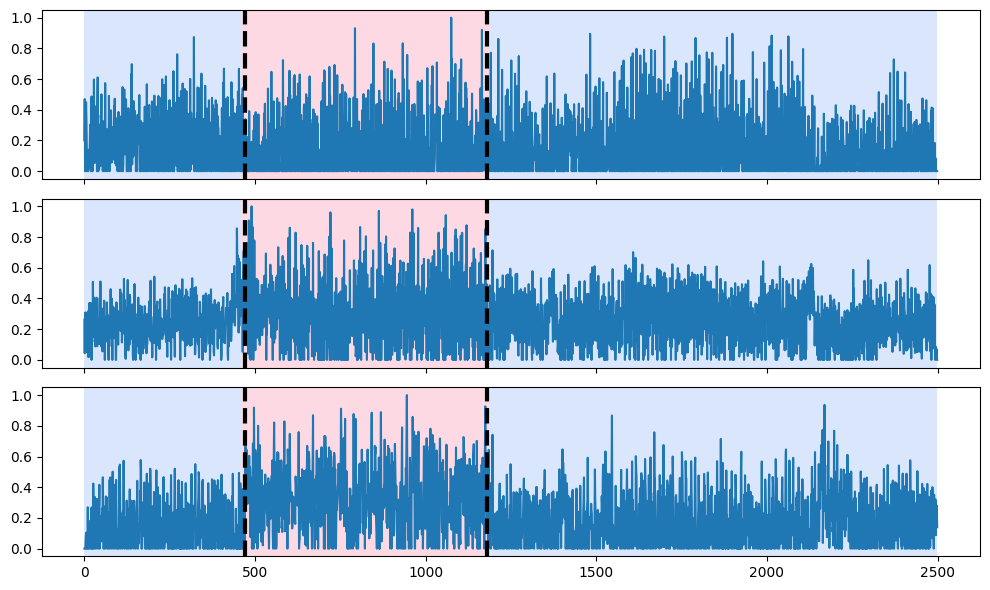

Signal n°  61
True segmentation : [  54  285  423  648  788  990 1123 1366 1518 2109 2500]
Predicted segmentation : [ 620 1100 1123 1539 2108 2500]
F1 score : 0.6666666666666666


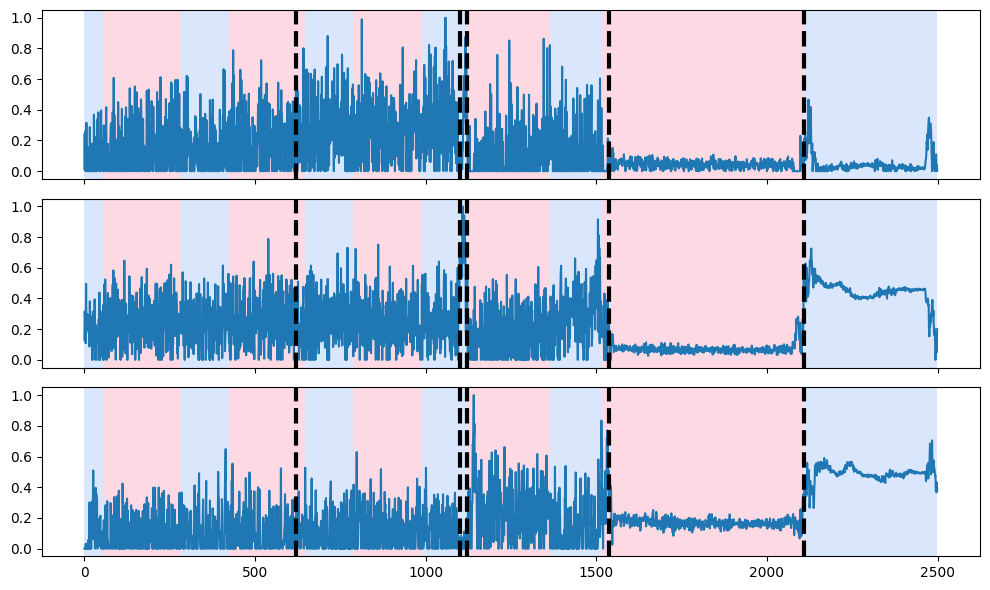

Signal n°  62
True segmentation : [ 835 2298 2500]
Predicted segmentation : [ 834 2306 2500]
F1 score : 1.0


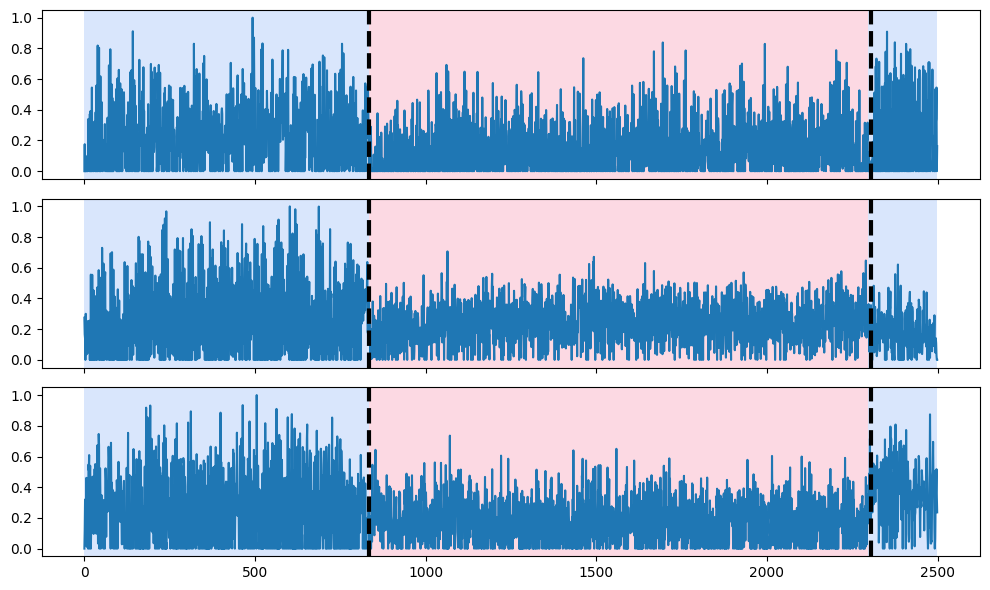

Signal n°  63
True segmentation : [1406 2500]
Predicted segmentation : [1394 2500]
F1 score : 1.0


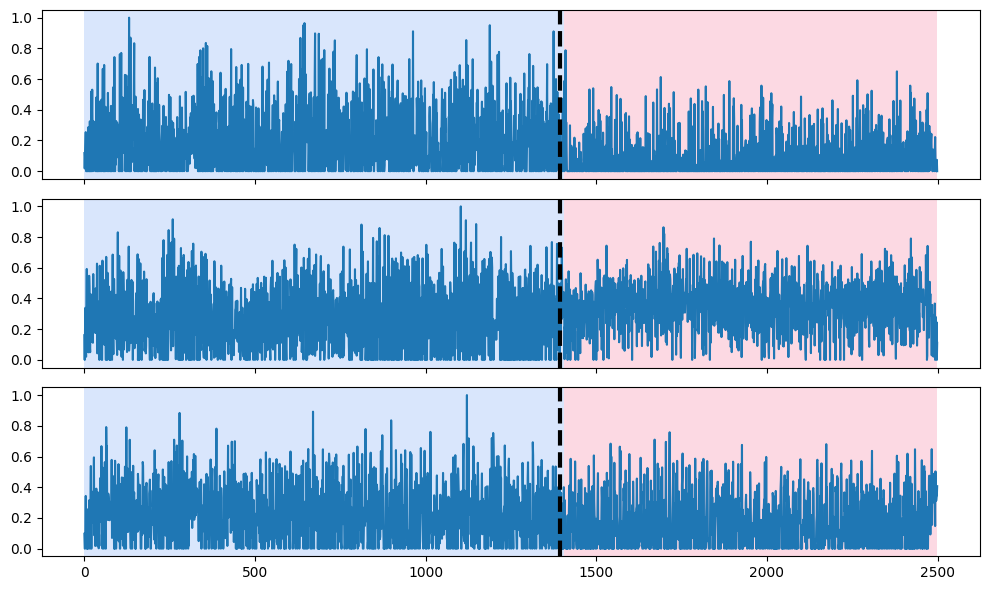

Signal n°  64
True segmentation : [ 377 1984 2500]
Predicted segmentation : [ 381 1978 2500]
F1 score : 1.0


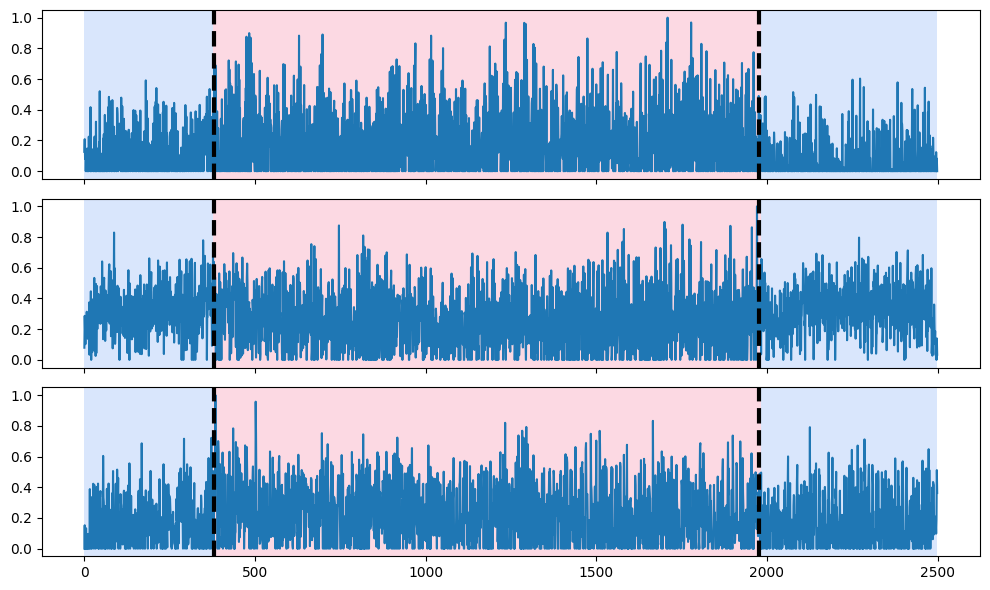

Signal n°  65
True segmentation : [ 955 1199 1374 1691 1846 2126 2295 2500]
Predicted segmentation : [ 993 1691 1848 2098 2500]
F1 score : 0.7272727272727273


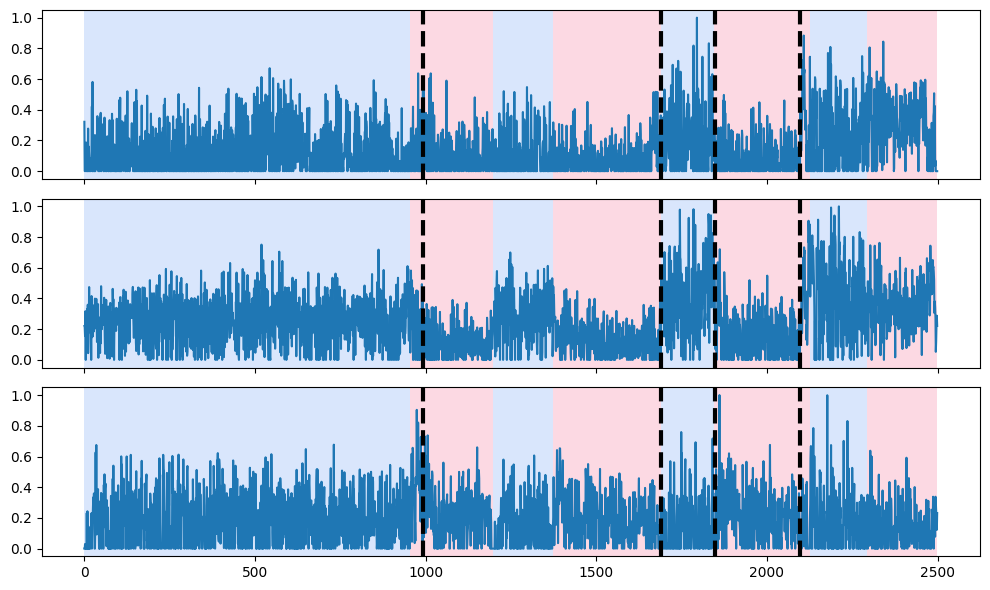

In [25]:
transformation_pipeline.display(X,y)

## Cross-Validation for Model Evaluation

We have implemented a convenient way to perform cross-validation on a model, adopting an approach with a fixed number of splits at each iteration to ensure robust evaluation of your model's performance. The provided function for this purpose is called `crossvalidate`.

You have the flexibility to adjust several parameters:
- **num_folds:** You can specify the number of folds or splits you want to use in the evaluation.
- **num_epochs:** Choose the number of epochs for training.
- **batch_size:** Specify the batch size to be used during training.
- **margin_percentages:** Choose the margin for the F1 score computed as a percentage of the transformed signal length. By default, this is set to [5%, 4%, 3%, 2%, 1%].

The `crossvalidate` function will return, for each margin, a list of F1 scores computed on each signal of the database when the signal was part of the test split. Additionally, the function prints the mean and standard deviation of each margin.

In [26]:
X = wisdm_pre_process_sig
y = wisdm_size_adapted_jnp_segmentations 
model = transformation_pipeline
# Define the parameters of folds for cross-validation
num_folds = 3
num_epochs = 100
batch_size = 5
marges = [5/100, 4/100, 3/100, 2/100, 1/100]
test_scores = crossvalidate(model, X, y, num_folds, num_epochs, batch_size, verbose= False, marges = marges)

Starting Cross Validation for 3 splits and 100 epochs. (batch size : 5)
...


[[1.         0.         0.5        0.90909091 1.         0.4
  0.66666667 0.57142857 0.2        0.4        0.42857143 0.44444444
  0.22222222 1.         0.53333333 0.66666667 0.66666667 0.4
  0.25       0.44444444 0.4        0.57142857 0.66666667 0.5
  0.66666667 0.8        0.28571429 0.66666667 1.         0.8
  0.75       0.22222222 0.5        0.57142857 0.83333333 0.5
  1.         0.58823529 0.5        0.72727273 0.66666667 0.5
  0.53333333 1.         0.66666667 0.85714286 1.         0.66666667
  0.25       1.         0.5        0.57142857 0.5        0.5
  0.22222222 0.66666667 0.5        0.8        0.5        0.5
  0.66666667 0.66666667 0.83333333 1.         0.5        1.        ]
 [1.         0.         0.5        0.90909091 1.         0.4
  0.66666667 0.57142857 0.2        0.4        0.42857143 0.44444444
  0.22222222 1.         0.53333333 0.66666667 0.66666667 0.4
  0.25       0.44444444 0.4        0.71428571 0.66666667 0.5
  0.66666667 0.8        0.28571429 0.66666667 1.        